In [16]:
%matplotlib inline

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

In [18]:
import numpy as np

In [19]:
import pandas as pd
import torch
from nltk.corpus import wordnet as wn
pd.options.display.max_colwidth = 100
pd.set_option('display.max_colwidth', None)
from nltk.stem import WordNetLemmatizer 
import seaborn as sns

In [20]:
import numpy as np

## populate the bert/lstm predictions

In [21]:
df_test = pd.read_json("test_final.json")

In [22]:
df_test["lstm_pred"] = torch.load('lstm_pred.pt')
df_test["lstm_pred_label"] = torch.load('lstm_pred_label.pt')
df_test["bert_pred"] = torch.load('bert_pred.pt')
df_test["bert_pred_label"] = torch.load('bert_pred_label.pt')
df_test["cnn_pred"] = torch.load('cnn_pred.pt')
df_test["cnn_pred_label"] = torch.load('cnn_pred_label.pt')
df_test["cnn_surp"] = torch.load('surp_cnn_test.pt')
df_test["lstm_surp"] = torch.load('surp_lstm_test.pt')

In [23]:
df_test["bert_success"] = 1.0 * (df_test["bert_pred_label"] == df_test["label"])
df_test["lstm_success"] = 1.0 * (df_test["lstm_pred_label"] == df_test["label"])
df_test["cnn_success"] = 1.0 * (df_test["cnn_pred_label"] == df_test["label"])

In [24]:
df_test["bert_surp"] = np.load('bert_test_surps.npy')

In [25]:
df_test["bert_surp"] .values

array([1.84335864e+00, 6.94819748e-01, 5.87818492e-03, ...,
       7.62042236e+00, 1.22569389e+01, 9.46057796e+00])

# plotting functions

In [116]:
def plot_acc(df, labelx, model_list=["bert", "lstm", "cnn"], y_lims=(0.5,1.0), metric=None, pos_label=None, use_percentile=True,
            round_bins=False, bin_cen_num=True, rotate_label=False, xlabel=False,
            legend_names=["bert-base", "awd-lstm", "gated-cnn"], title_pos=None, do_title=False):
 
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.gca()
    for idx, model_name in enumerate(model_list):
        K = 10
        if use_percentile:
            non_boundary_bin_edges = np.array([np.percentile(df[labelx], i) for i in range(K,100,K)])
            bins_edges = np.zeros(len(non_boundary_bin_edges)+2)
            bins_edges[1:-1] = non_boundary_bin_edges
            bins_edges[0], bins_edges[-1] = min(df[labelx]), max(df[labelx])
            
            num_bins = len(non_boundary_bin_edges) + 1
            print(non_boundary_bin_edges)
            print([np.sum(df[labelx] >t) for t in non_boundary_bin_edges])

            bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
            sample_bin_ids = np.digitize(df[labelx], non_boundary_bin_edges)
            
            num_samples_in_bins = np.zeros(num_bins)
            acc_in_bins = np.zeros(num_bins)
            #acc_in_bins_std = np.zeros(num_bins)

            for bin in range(num_bins):
                num_samples_in_bins[bin] = len(df[model_name + "_success"][sample_bin_ids == bin])
                if num_samples_in_bins[bin] > 0:
                    #acc_in_bins[bin] = np.sum(df[model_name + "_success"][sample_bin_ids == bin]) / num_samples_in_bins[bin]
                    if metric.__name__ != "accuracy_score":
                        acc_in_bins[bin] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin],
                                                 pos_label=pos_label)
                    elif metric.__name__ == "accuracy_score":
                        acc_in_bins[bin] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin])
                    
        else:
            if bin_cen_num:
                bin_centers = np.array(list(range(min(df[labelx]), max(df[labelx])+1)))
                sample_bin_ids = df[labelx]
                
            else:
                bin_centers = sorted(df[labelx].unique())
                sample_bin_ids = df[labelx]
                
            num_bins = len(bin_centers)
            num_samples_in_bins = np.zeros(num_bins)
            acc_in_bins = np.zeros(num_bins)
            #acc_in_bins_std = np.zeros(num_bins)

            for i, bin in enumerate(bin_centers):
                num_samples_in_bins[i] = len(df[model_name + "_success"][sample_bin_ids == bin])
                if num_samples_in_bins[i] > 0:
                    #acc_in_bins[bin] = np.sum(df[model_name + "_success"][sample_bin_ids == bin]) / num_samples_in_bins[bin]
                    if metric.__name__ != "accuracy_score":
                        acc_in_bins[i] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin],
                                                 pos_label=pos_label)
                    else:
                        acc_in_bins[i] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin])
        
                    

        plt.plot(bin_centers,
                 acc_in_bins,
                 's--',
                 label=legend_names[idx],
                 linewidth=2,
                 markersize=10,
                )
        #plt.fill_between(bin_centers,
        #                 acc_in_bins-acc_in_bins_std,
        #                 acc_in_bins+acc_in_bins_std,
        #                 alpha=0.1
        #                )
        #plt.plot(bin_centers, 1.0* num_samples_in_bins/np.sum(num_samples_in_bins), '^--')
        #print(1.0* num_samples_in_bins/np.sum(num_samples_in_bins))
        if xlabel:
            plt.xlabel(xlabel)
        else:
            plt.xlabel(labelx)
        plt.ylabel(metric.__name__)
        plt.ylim(y_lims)
    plt.legend(fontsize=18)
    plt.grid()
    if do_title:
        if pos_label:
            plt.title("query seen", y=title_pos)
        else:
            plt.title("query unseen", y=title_pos)
    if rotate_label:
        ax.set_xticklabels(bin_centers, fontsize=12, rotation=90)
    plt.savefig(labelx+"_metric"+metric.__name__+"_pos_label_"+str(pos_label)+"_.png", 
               bbox_inches='tight', 
               transparent=True)

In [207]:
labelx = 'num_rep'
prop = df_test.groupby([labelx], group_keys=False).apply(lambda x: x['bert_success'].mean())
print(min(prop.index))
print(max(prop.index))

0
143


In [312]:
"this is".split(" ").count("i")

0

In [49]:
df_test.head()

,query,context,label,context_length,bert_token_length,lstm_token_length,lstm_pred,lstm_pred_label,bert_pred,bert_pred_label,cnn_pred,cnn_pred_label,cnn_surp,lstm_surp,bert_success,lstm_success,cnn_success,bert_surp
19021,'an,"Even before he had begun work , however , the position was swept away by events . War The An Lushan Rebellion began in December 755 , and was not completely suppressed for almost eight years . It caused enormous disruption to Chinese society the census of 754 recorded 52 . 9 million people , but ten years later , the census counted just 16 . 9 million , the remainder having been displaced or killed . During this time , Du Fu led a largely itinerant life unsettled by wars , associated famines and imperial displeasure . This period of unhappiness was the making of Du Fu as a poet Even Shan Chou has written that , What he saw around him the lives of his family , neighbors , and strangers what he heard , and what he hoped for or feared from the progress of various campaigns these became the enduring themes of his poetry . Even when he learned of the death of his youngest child , he turned to the suffering of others in his poetry instead of dwelling upon his own misfortunes . Du Fu wrote Brooding on what I have lived through , if even I know such suffering , the common man must surely be rattled by the winds . In 756 , Emperor Xuanzong was forced to flee the capital and abdicate . Du Fu , who had been away from the city , took his family to a place of safety and attempted to join the court of the new emperor , but he was captured by the rebels and taken to Chang 'an . In the autumn , his youngest son , Du Baby Bear , was born . Around this time Du Fu is thought to have contracted malaria . He escaped from Chang",1,306,334,346,0.083473,0.0,0.999999,1.0,0.002901,0.0,1.223808,10.548165,1.0,0.0,0.0,1.843359
20309,'an,"9 million people , but ten years later , the census counted just 16 . 9 million , the remainder having been displaced or killed . During this time , Du Fu led a largely itinerant life unsettled by wars , associated famines and imperial displeasure . This period of unhappiness was the making of Du Fu as a poet Even Shan Chou has written that , What he saw around him the lives of his family , neighbors , and strangers what he heard , and what he hoped for or feared from the progress of various campaigns these became the enduring themes of his poetry . Even when he learned of the death of his youngest child , he turned to the suffering of others in his poetry instead of dwelling upon his own misfortunes . Du Fu wrote Brooding on what I have lived through , if even I know such suffering , the common man must surely be rattled by the winds . In 756 , Emperor Xuanzong was forced to flee the capital and abdicate . Du Fu , who had been away from the city , took his family to a place of safety and attempted to join the court of the new emperor , but he was captured by the rebels and taken to Chang 'an . In the autumn , his youngest son , Du Baby Bear , was born . Around this time Du Fu is thought to have contracted malaria . He escaped from Chang",1,255,280,286,0.068632,0.0,1.000000,1.0,0.002901,0.0,1.223808,10.476704,1.0,0.0,0.0,0.694820
20838,'an,"9 million , the remainder having been displaced or killed . During this time , Du Fu led a largely itinerant life unsettled by wars , associated famines and imperial displeasure . This period of unhappiness was the making of Du Fu as a poet Even Shan Chou has written that , What he saw around him the lives of his family , neighbors , and strangers what he heard , and what he hoped for or feared from the progress of various campaigns these became the enduring themes of his poetry . Even when he learned of the death of his youngest child , he turned to the suffering of others in his poetry instead of dwelling upon his own misfortunes . Du Fu wrote Brooding on what I have lived through , if even I know such suffering , the common man must surely be rattled by the win

## attributes such as number of reps, intervening tokens, number of meanings, word count

In [44]:
def get_count(c, q):
    try:
        count = c.split(" ").count(q)
    except:
        
        count = -1
    
    return count

In [101]:
def get_intervening_tokens(c, q, l):
    try:
        int_tok = 512 - c.split(" ").index(q) - 1
    except:
        int_tok = -1
    
    return int_tok

In [51]:
def get_synsets(a):
    return len(wn.synsets(a))

In [52]:
def get_word_length(q):
    return len(q)

In [53]:
def get_first_rep(c, q):
    try:
        first_pos = c.split(" ").index(q)
    except:
        first_pos = -1
    
    return first_pos

In [102]:
df_test["num_rep"] = df_test.apply(lambda x: get_count(x['context'], x['query']), axis=1)
df_test["int_tok"] = df_test.apply(lambda x: get_intervening_tokens(x['context'], x['query'], x['context_length']), axis=1) 

In [19]:
df_test[df_test["num_rep"] > 300]["query"].values.tolist()

[]

In [197]:
df_test = df_test[df_test["query"]!='']

In [55]:
df_test["num_meanings"] = df_test["query"].apply(get_synsets)

In [56]:
df_test["word_length"] = df_test.apply(lambda x: len(x["query"]), axis=1)

In [57]:
df_test["first_pos"] = df_test.apply(lambda x: get_first_rep(x['context'], x['query']), axis=1)

In [58]:
bert_acc_context_length = df_test.groupby(["context_length"], group_keys=False).apply(lambda x: x['bert_success'].mean())
lstm_acc_context_length = df_test.groupby(["context_length"], group_keys=False).apply(lambda x: x['lstm_success'].mean())

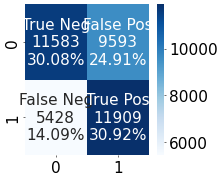

In [59]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(4, 4), dpi=50)
cf_matrix = confusion_matrix(df_test['label'], df_test['bert_pred_label'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('bert_confusion_matrix.png')



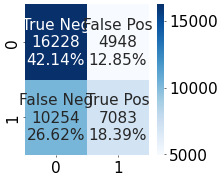

In [60]:
plt.figure(figsize=(4, 4), dpi=50)
cf_matrix = confusion_matrix(df_test['label'], df_test['lstm_pred_label'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('lstm_confusion_matrix.png')

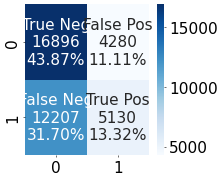

In [61]:
plt.figure(figsize=(4, 4), dpi=50)
cf_matrix = confusion_matrix(df_test['label'], df_test['cnn_pred_label'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('cnn_confusion_matrix.png')

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [63]:
precision_score.__name__

'precision_score'

In [71]:
from functools import partial

In [74]:
f1_macro = partial(f1_score, average="macro")
f1_macro.__name__ = f1_score.__name__

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


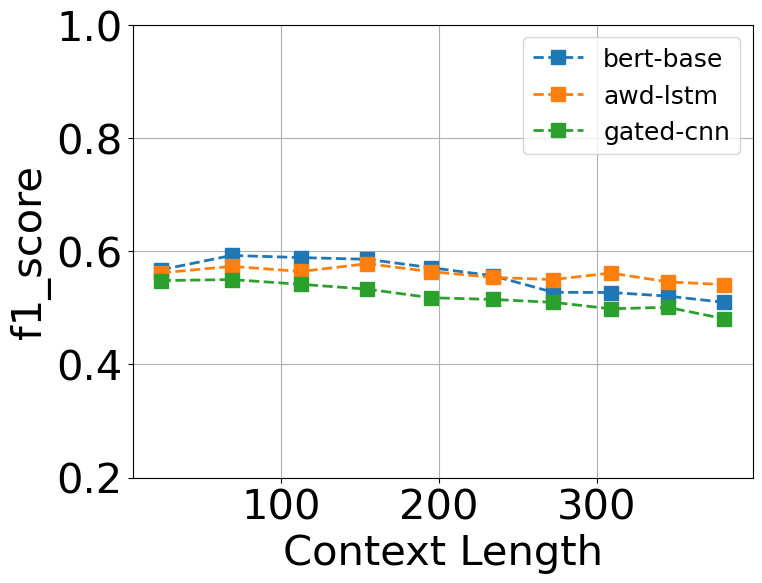

In [124]:
plot_acc(df_test, 'context_length', y_lims=(0.2,1.0), metric=f1_macro, pos_label=None, xlabel="Context Length") #, title_pos=(0.1,0.8))

[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]


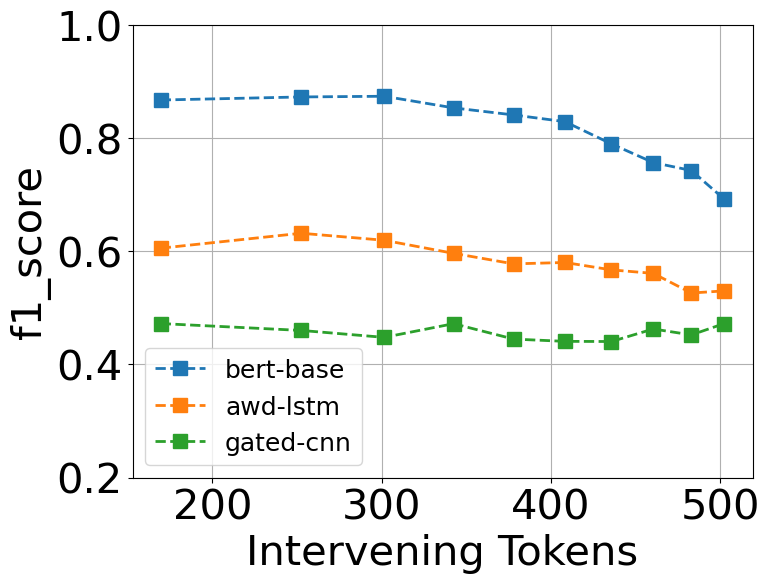

In [125]:
plot_acc(df_test[df_test['int_tok']>=0], 'int_tok', y_lims=(0.2,1.0), metric=f1_score, pos_label=1, 
         xlabel='Intervening Tokens')

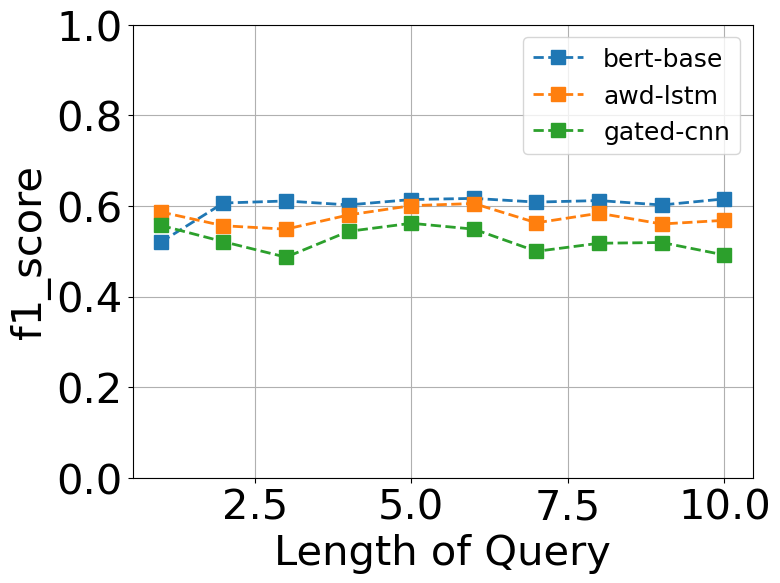

In [126]:
plot_acc(df_test[(df_test["word_length"]<11) & (df_test["word_length"]>0) ], 'word_length', y_lims=(0,1.0),
         metric=f1_macro, use_percentile=False, xlabel='Length of Query')

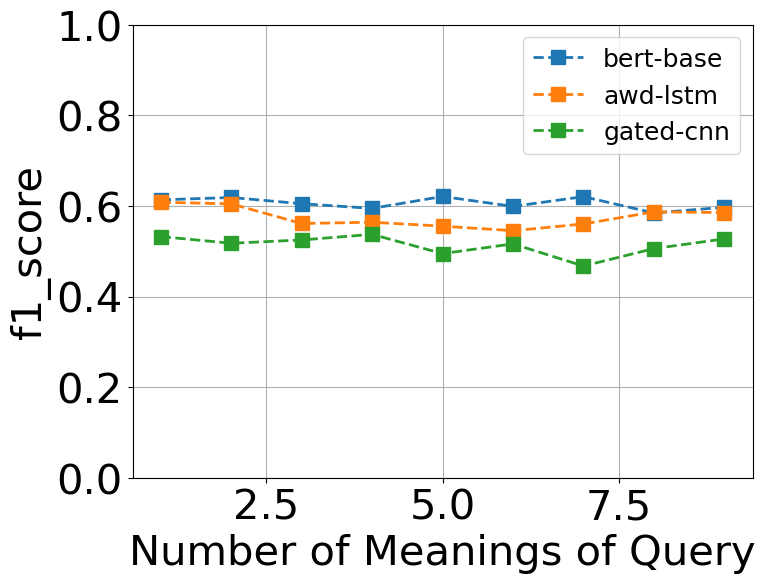

In [127]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', y_lims=(0,1.0),
         metric=f1_macro, use_percentile=False, xlabel='Number of Meanings of Query')

# below are old

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


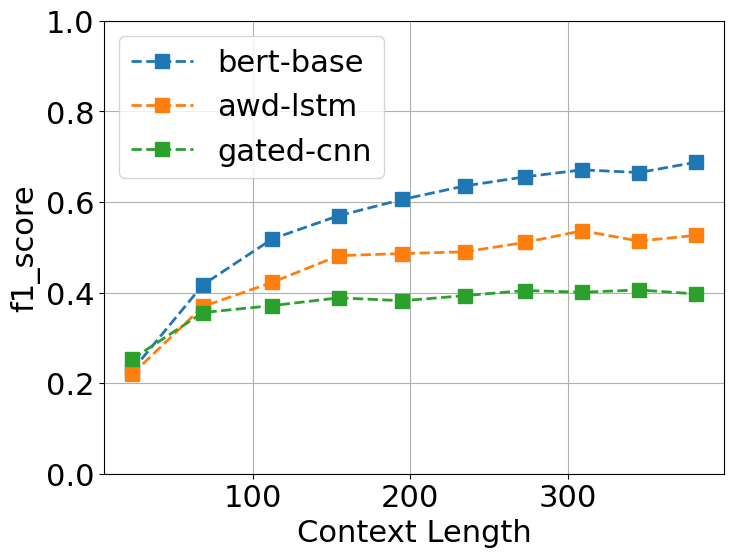

In [91]:
plot_acc(df_test, 'context_length', y_lims=(0.0,1.0), metric=f1_score, pos_label=1)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


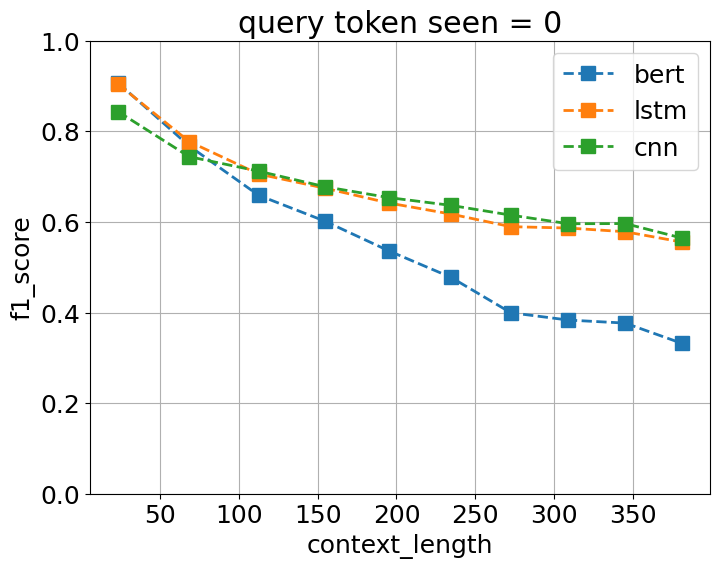

In [172]:
plot_acc(df_test, 'context_length', ["bert", "lstm", "cnn"], (0.0,1.0), metric=f1_score, pos_label=0)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


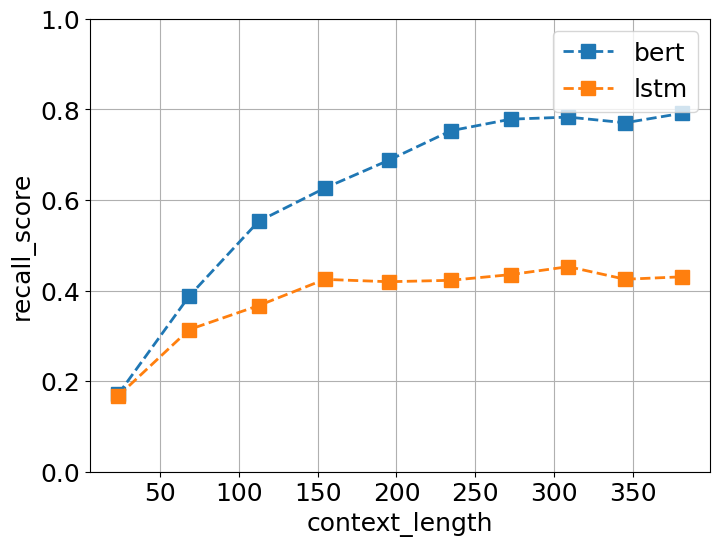

In [247]:
plot_acc(df_test, 'context_length', ["bert", "lstm"], (0.0,1.0), metric=recall_score)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


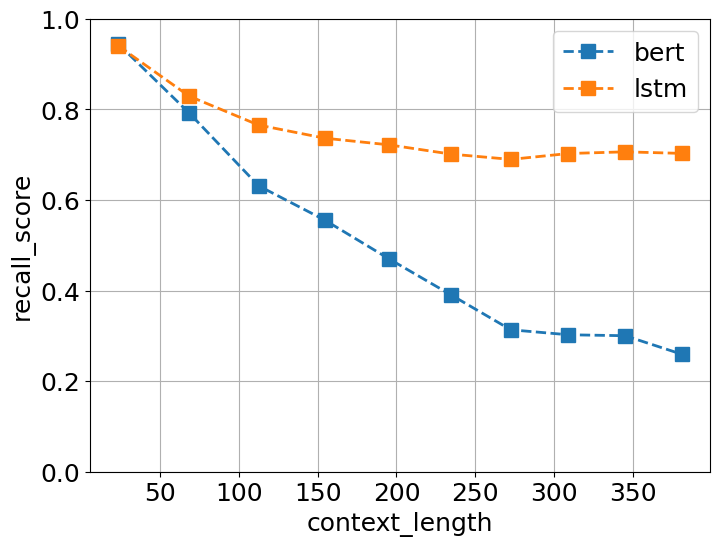

In [248]:
plot_acc(df_test, 'context_length', ["bert", "lstm"], (0.0,1.0), metric=recall_score, pos_label=0)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


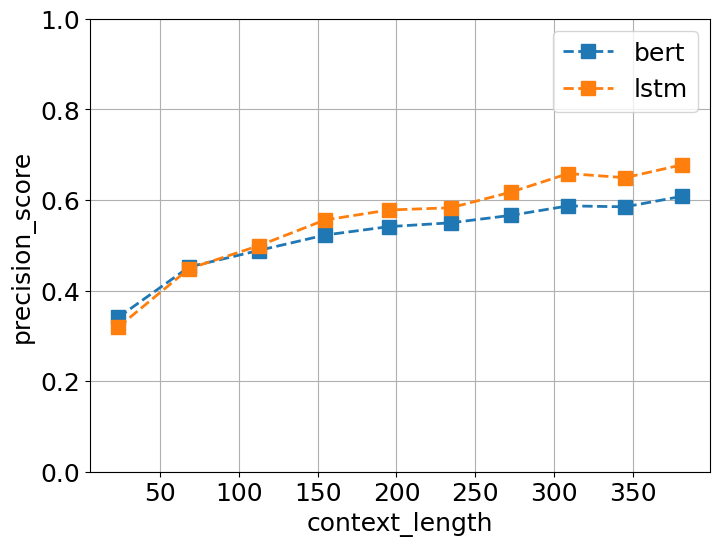

In [249]:
plot_acc(df_test, 'context_length', ["bert", "lstm"], (0.0,1.0), metric=precision_score)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34644, 30753, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


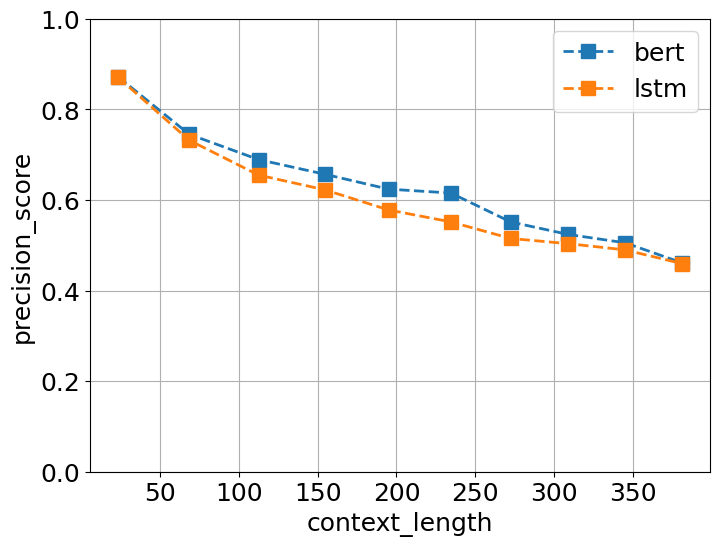

In [250]:
plot_acc(df_test, 'context_length', ["bert", "lstm"], (0.0,1.0), metric=precision_score, pos_label=0)

[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]
[ 46.  91. 134. 175. 215. 254. 291. 327. 363.]
[34645, 30754, 26845, 23068, 19192, 15326, 11482, 7696, 3764]


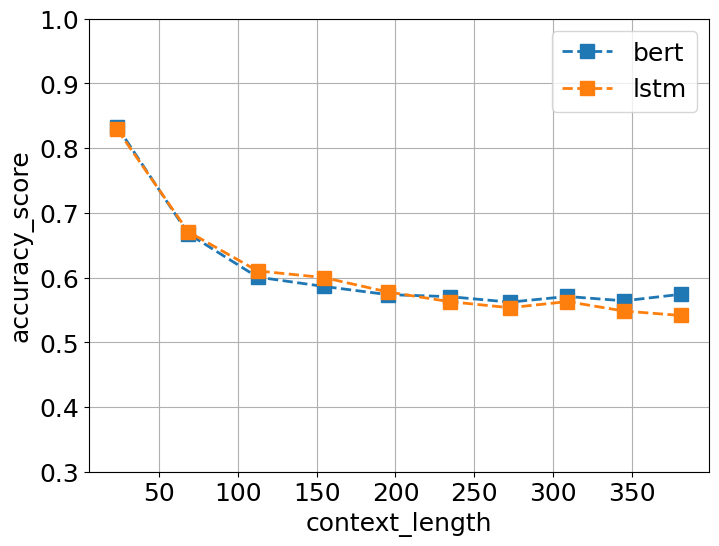

In [42]:
plot_acc(df_test, 'context_length', ["bert", "lstm"], (0.3,1.0), metric=accuracy_score)

[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]


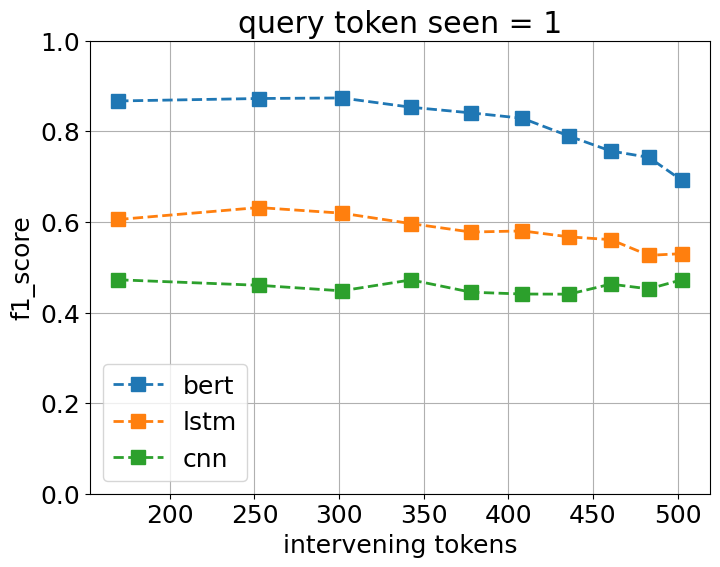

In [173]:
plot_acc(df_test[df_test['int_tok']>=0], 'int_tok', ["bert", "lstm", "cnn"], (0,1.0), metric=f1_score, xlabel='intervening tokens')

[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]


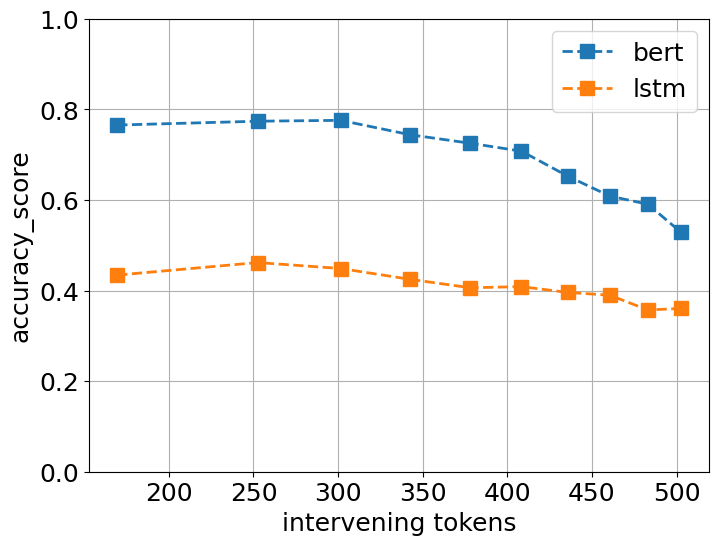

In [47]:
plot_acc(df_test[df_test['int_tok']>=0], 'int_tok', ["bert", "lstm"], (0,1.0), metric=accuracy_score, pos_label=0, xlabel='intervening tokens')

[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]
[225.  280.  323.  362.  394.  422.6 449.  472.  494. ]
[15591, 13846, 12121, 10351, 8654, 6935, 5131, 3444, 1662]


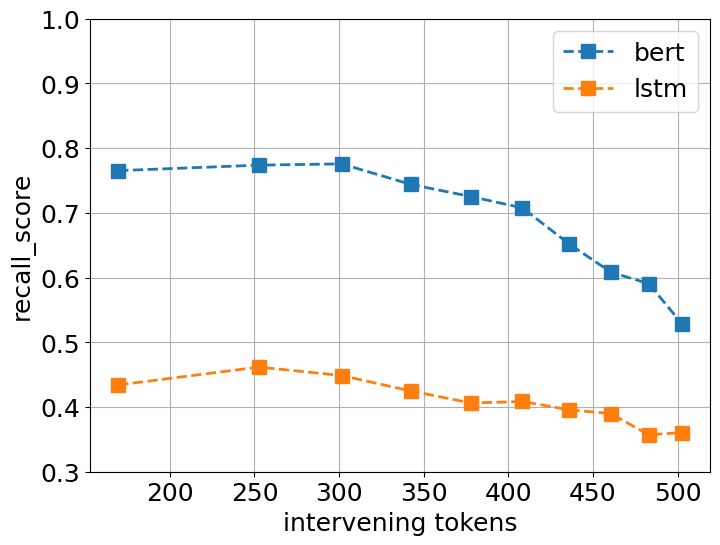

In [41]:
plot_acc(df_test[df_test['int_tok']>=0], 'int_tok', ["bert", "lstm"], (0.3,1.0), metric=recall_score, xlabel='intervening tokens')

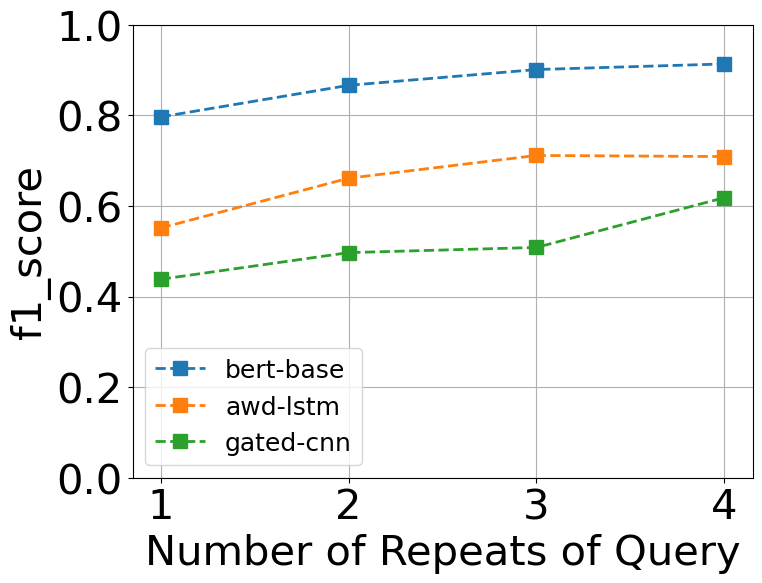

In [154]:
plot_acc(df_test[(df_test['num_rep']> 0) & (df_test['num_rep']< 5)], 'num_rep', ["bert", "lstm", "cnn"], (0,1.0),
         metric=f1_score,
         use_percentile=False,
         pos_label=1,
        round_bins=True, xlabel='Number of Repeats of Query')

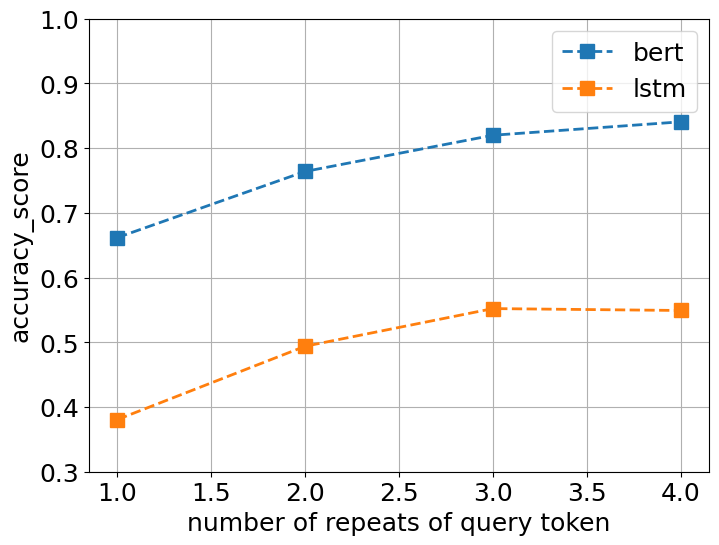

In [48]:
plot_acc(df_test[(df_test['num_rep']> 0) & (df_test['num_rep']< 5)], 'num_rep', ["bert", "lstm"], (0.3,1), metric=accuracy_score,
         use_percentile=False,
        round_bins=True, xlabel='number of repeats of query token')

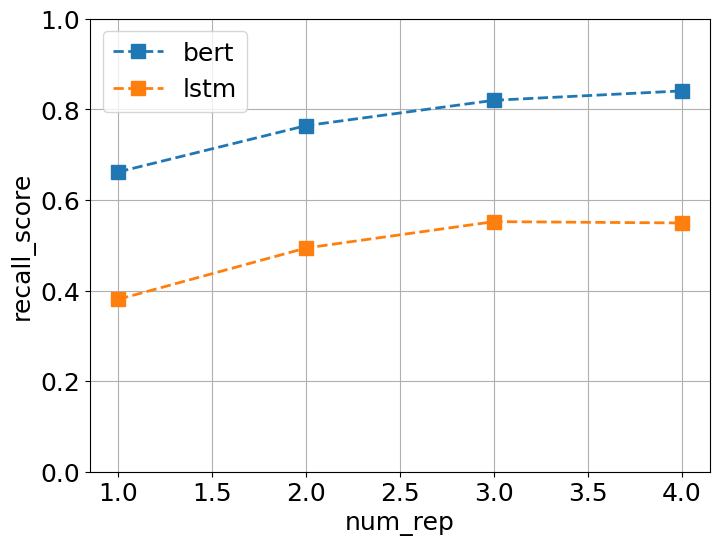

In [339]:
plot_acc(df_test[(df_test['num_rep']> 0) & (df_test['num_rep']< 5)], 'num_rep', ["bert", "lstm"], (0,1), metric=recall_score,
         use_percentile=False,
        round_bins=True)

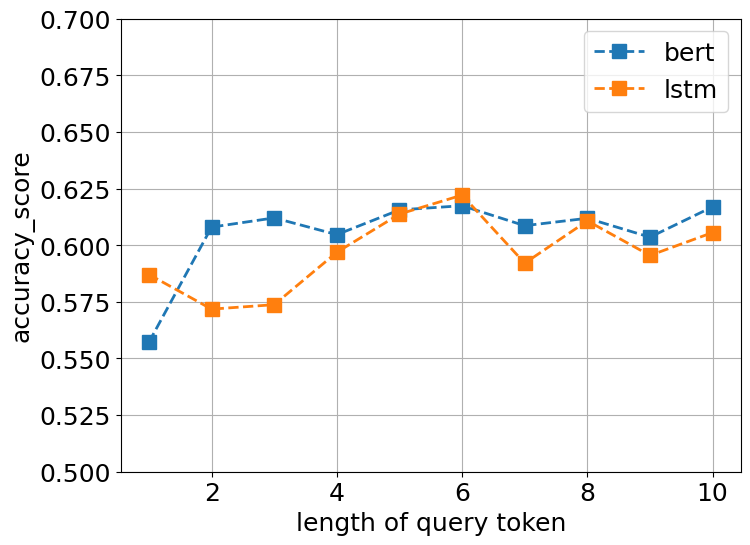

In [56]:
plot_acc(df_test[(df_test["word_length"]<11) & (df_test["word_length"]>0)], 'word_length', ["bert", "lstm"], (0.5,0.7), metric=accuracy_score, use_percentile=False, xlabel='length of query token')

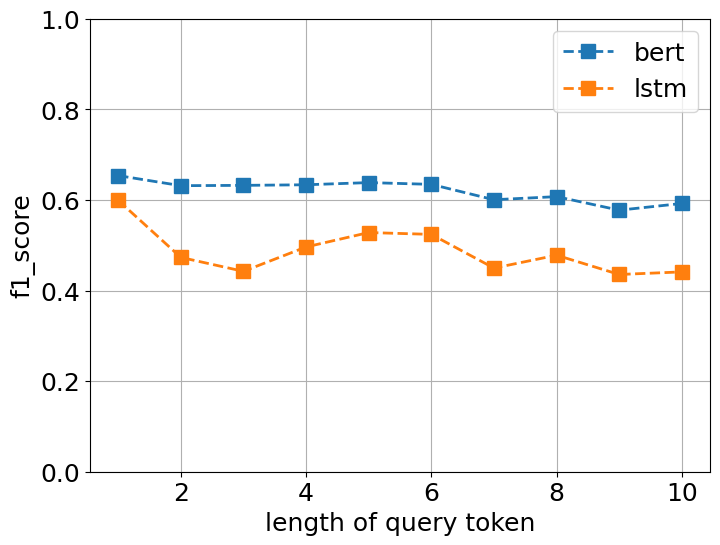

In [57]:
plot_acc(df_test[(df_test["word_length"]<11) & (df_test["word_length"]>0) ], 'word_length', ["bert", "lstm"], (0,1.0), metric=f1_score, use_percentile=False, xlabel='length of query token')

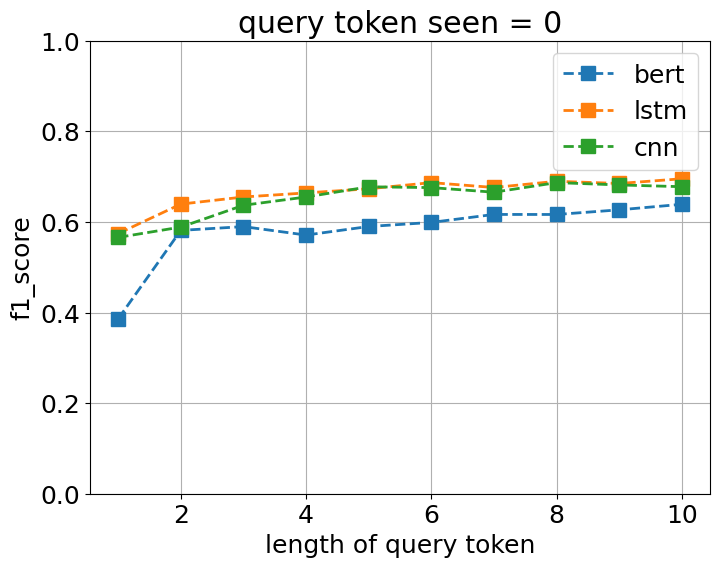

In [175]:
plot_acc(df_test[(df_test["word_length"]<11) & (df_test["word_length"]>0) ], 'word_length', ["bert", "lstm", "cnn"], (0,1.0), metric=f1_score, use_percentile=False, pos_label=0, xlabel='length of query token')

/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


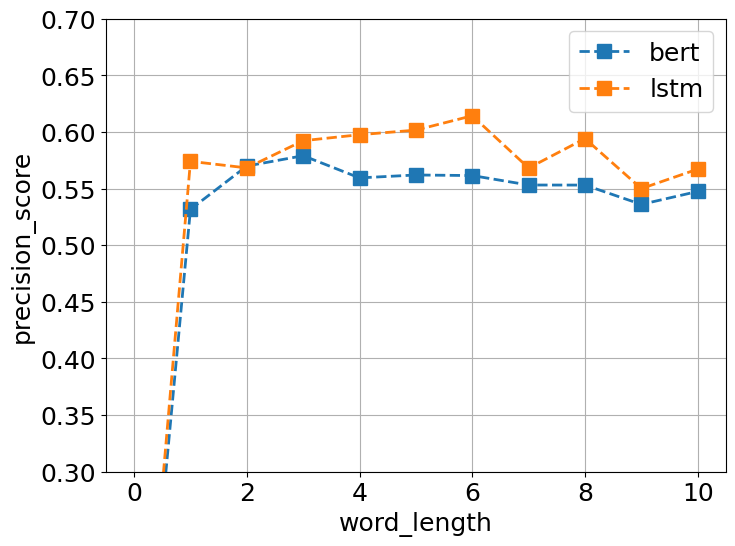

In [52]:
plot_acc(df_test[df_test["word_length"]<11], 'word_length', ["bert", "lstm"], (0.3,0.7), metric=precision_score, use_percentile=False)

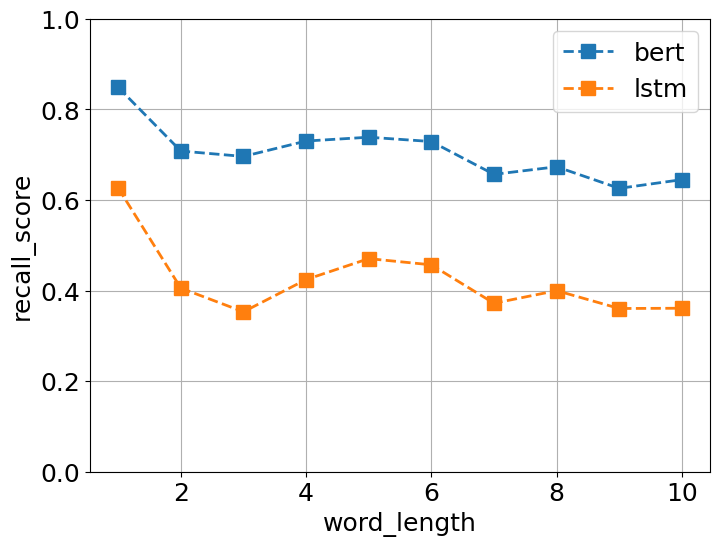

In [354]:
plot_acc(df_test[df_test["word_length"]<11], 'word_length', ["bert", "lstm"], (0.0,1.0), metric=recall_score, use_percentile=False)

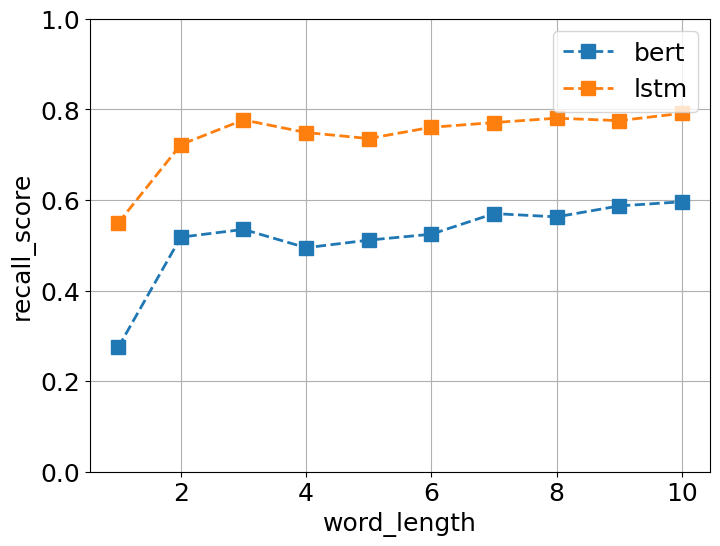

In [355]:
plot_acc(df_test[df_test["word_length"]<11], 'word_length', ["bert", "lstm"], (0.0,1.0), metric=recall_score,
         use_percentile=False, pos_label=0)

In [347]:
len(df_test[df_test["word_length"]>15])

23

In [371]:
df_test[df_test["num_meanings"]==0]["query"].unique()

array(["'an", "'o", "'re", "'s", "'ve", '274th', 'A.', 'Abaco', 'Adolf',
       'Against', 'Agok', 'Airlanding', 'Aldington', 'Although', 'Ames',
       'Amy', 'Anders', 'Anker', 'Applebee', 'Austro', 'BDA', 'Badgley',
       'Bah', 'Barbara', 'Barbra', 'Because', 'Bentley', 'Bert',
       'Binondo', 'Bintulu', 'Bischoff', 'Blomfield', 'Blu', 'Brock',
       'CDM', 'Cardano', 'Carolyn', 'Carwin', 'Cerro', 'Changnyong',
       'Cheshire', 'Choi', 'Claxton', 'Cocceius', 'Covina', 'Craig',
       'Cristobal', 'Cy', 'Dayak', 'Dickstein', 'Dodd', 'Doherty',
       'Dolin', 'Domitius', 'Drenstein', 'Drusus', 'Dujuan', 'Eamonn',
       'Eddie', 'Ericsson', 'F.', 'FSM', 'FSNs', 'Facebook', 'Fitts',
       'Flavian', 'Flavians', 'For', 'From', 'Fuiste', 'Fuzhou', 'GCL',
       'Geelong', 'Geer', 'Gen.', 'Germania', 'Glassman', 'Gloire',
       'Gospi', 'Grammy', 'HAL', 'HMT', 'Hainan', 'Hankin', 'Hannah',
       'Henderson', 'Her', 'His', 'Honeywell', 'How', 'Hugh', 'Hulme',
       'Iglesia', '

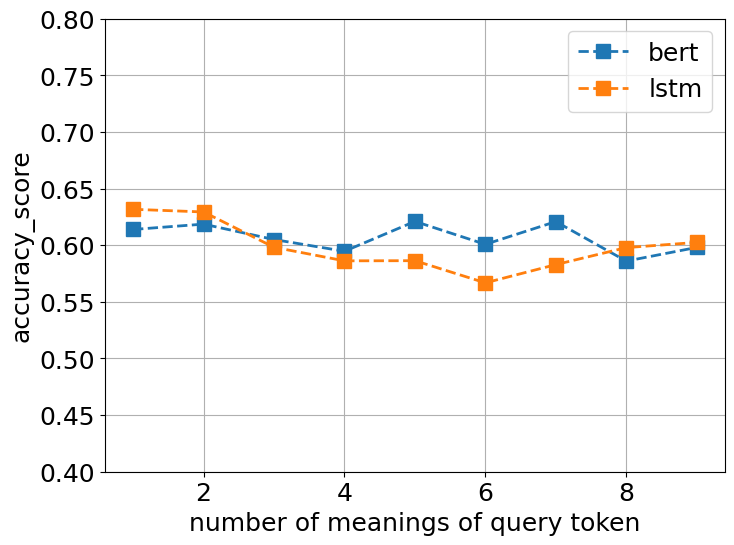

In [62]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.4,0.8),
         metric=accuracy_score, use_percentile=False, xlabel='number of meanings of query token')

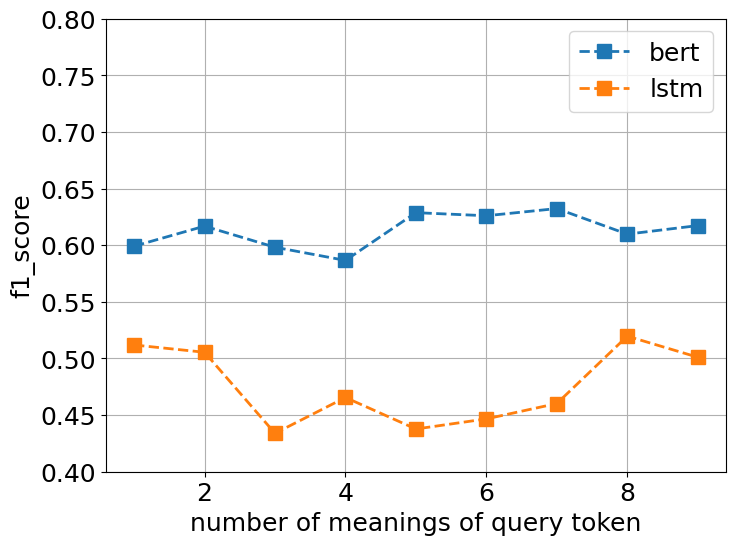

In [63]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.4,0.8),
         metric=f1_score, use_percentile=False, xlabel='number of meanings of query token')

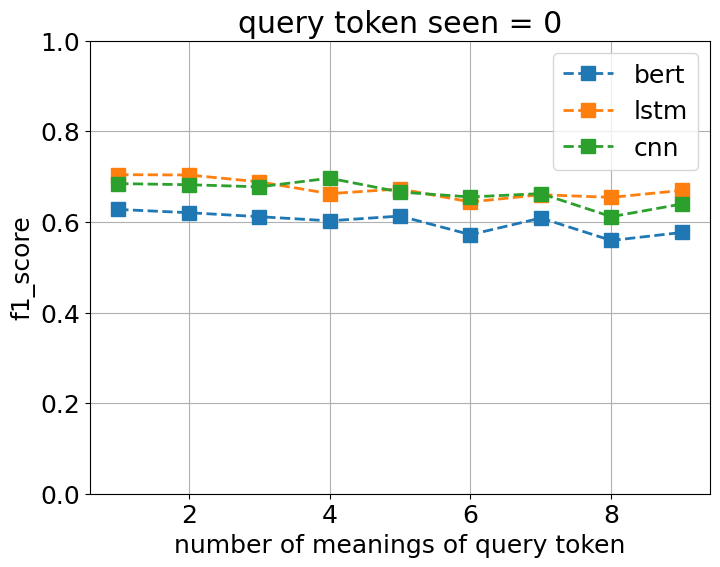

In [176]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm", "cnn"], (0,1.0),
         metric=f1_score, pos_label= 0, use_percentile=False, xlabel='number of meanings of query token')

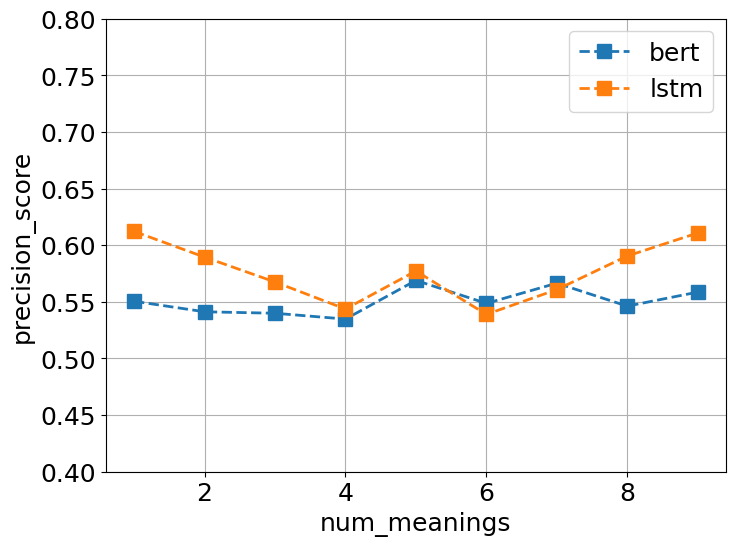

In [376]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.4,0.8),
         metric=precision_score, use_percentile=False)

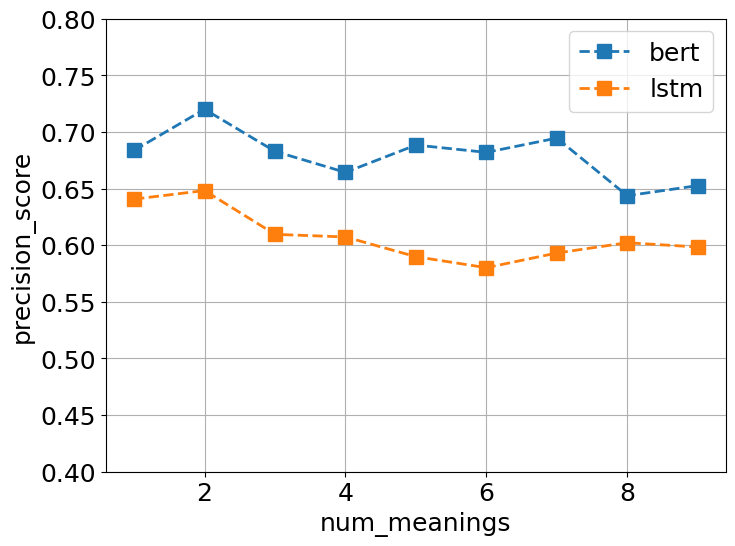

In [380]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.4,0.8),
         metric=precision_score, use_percentile=False, pos_label=0)
# comments: if there are more meanings for a word it is harder to tell whether it has seen it before, because 
# it is more likely that there are other words that have similar meaning

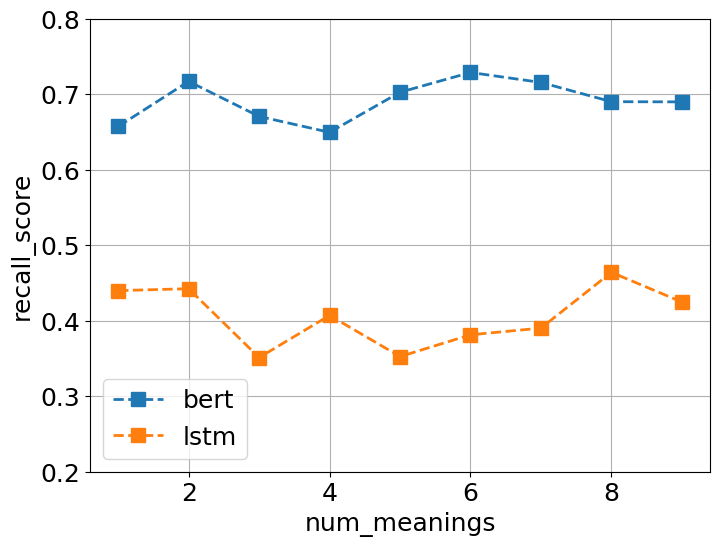

In [378]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.2,0.8),
         metric=recall_score, use_percentile=False)

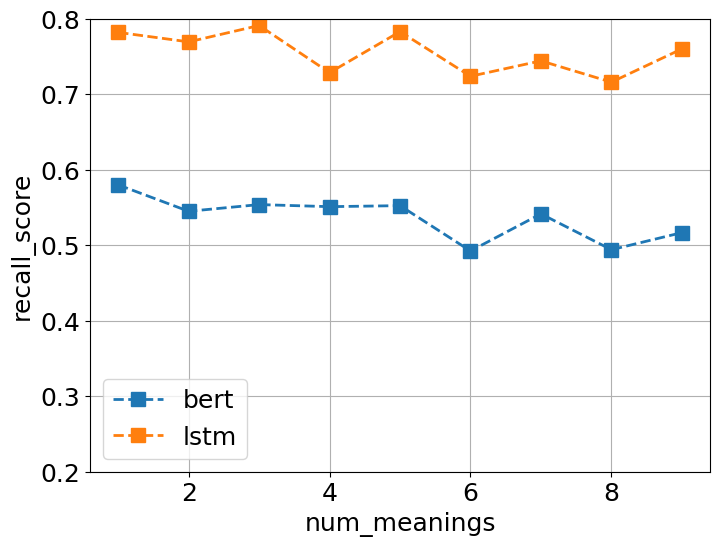

In [379]:
plot_acc(df_test[(df_test["num_meanings"]>0) & (df_test["num_meanings"]<10)],
         'num_meanings', ["bert", "lstm"], (0.2,0.8),
         metric=recall_score, use_percentile=False, pos_label=0)

In [179]:
len(df_test[df_test["num_meanings"] > 50]["query"].unique())

10

[ 17.   39.   62.   88.4 117.  149.  188.  231.  286. ]
[15584, 13811, 12133, 10402, 8630, 6931, 5170, 3458, 1721]
[ 17.   39.   62.   88.4 117.  149.  188.  231.  286. ]
[15584, 13811, 12133, 10402, 8630, 6931, 5170, 3458, 1721]


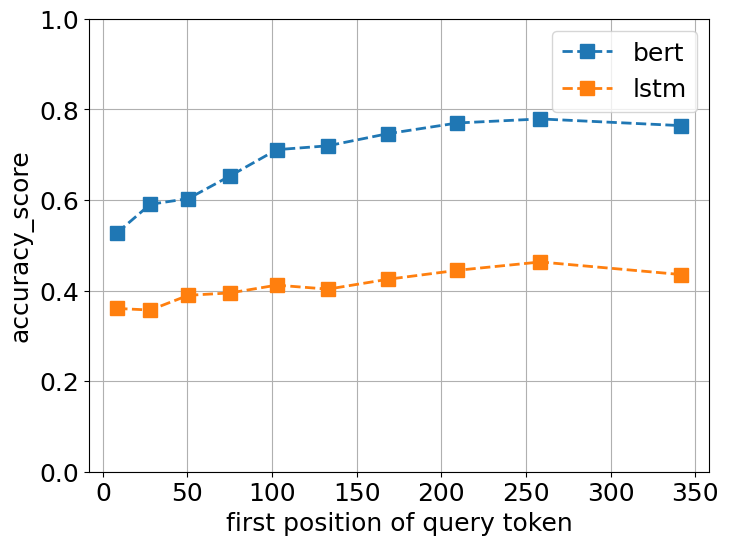

In [66]:
plot_acc(df_test[df_test['first_pos']>-1], 'first_pos', ["bert", "lstm"], (0,1), metric=accuracy_score, xlabel='first position of query token')

[ 17.   39.   62.   88.4 117.  149.  188.  231.  286. ]
[15584, 13811, 12133, 10402, 8630, 6931, 5170, 3458, 1721]
[ 17.   39.   62.   88.4 117.  149.  188.  231.  286. ]
[15584, 13811, 12133, 10402, 8630, 6931, 5170, 3458, 1721]
[ 17.   39.   62.   88.4 117.  149.  188.  231.  286. ]
[15584, 13811, 12133, 10402, 8630, 6931, 5170, 3458, 1721]


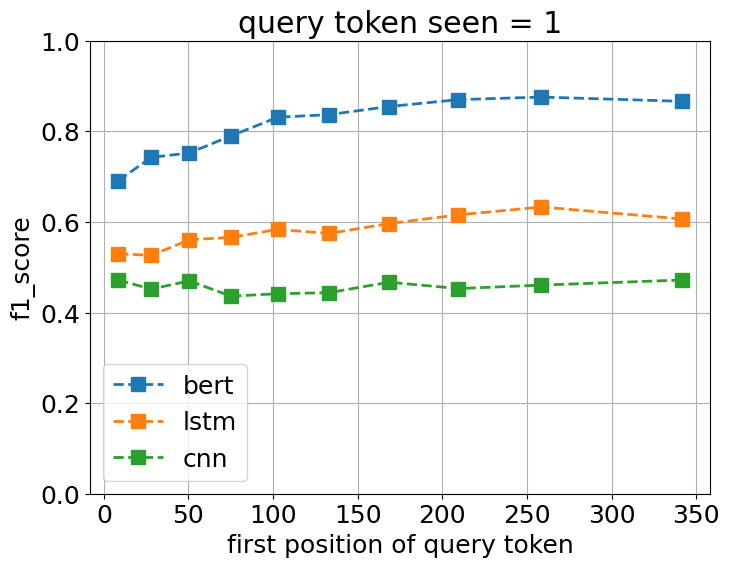

In [177]:
plot_acc(df_test[df_test['first_pos']>-1], 'first_pos', ["bert", "lstm", "cnn"], (0,1), metric=f1_score, xlabel='first position of query token')

## get vad

In [141]:
# for the VAD values read from NRC-VAD-Lexicon.txt
columns = ["word", "valence", "arousal", "dominance"]
vad_df = pd.DataFrame(columns=columns)

import csv

word_list = []
valence = []
arousal = []
dominance = []

with open("NRC-VAD-Lexicon.txt") as tsv:
    for line in csv.reader(tsv, delimiter='\t'):
        word_list.append(line[0])
        valence.append(line[1])
        arousal.append(line[2])
        dominance.append(line[3])

vad_df["word"] = word_list
vad_df["valence"] = valence
vad_df["arousal"] = arousal
vad_df["dominance"] = dominance

In [142]:
vad_words = vad_df["word"].values.tolist()

In [143]:
def get_vad(df, vad_df):
    df = pd.merge(df, vad_df, how='left', left_on = 'query', right_on = "word")
    df = df.drop(columns = ["word"])
    return df

In [144]:
df_test = get_vad(df_test, vad_df)

In [145]:
df_test_vad.head()

,query,context,label,context_length,bert_token_length,lstm_token_length,lstm_pred,lstm_pred_label,bert_pred,bert_pred_label,bert_success,lstm_success,num_rep,int_tok,num_meanings,word_length,first_pos,valence,arousal,dominance
6639,ability,"The secret to basketball and life is just to do the job to the best of your ability and don 't worry about anything else , Stevens says . Win the next game . Win the next possession . That 's our focus . It 's boring . It 's also the way championships are won , he says . In short , Stevens is a strong believer in The Butler Way doing all the little things that transform a group of good basketball players into a great basketball team . I tell the players ' the Butler Way ' isn 't easy to define , Stevens says , but you can see it on the floor when we share the basketball , play with great energy and defend . Stevens prefers to recruit strong team players instead of going after top recruits . The guys we have recruited , most of them weren 't very highly ranked , Stevens says . They had very good high school careers or careers at other places transfers , but for one reason or the other they weren 't seen as great players . But they all had intangibles . Stevens puts a strong emphasis on education and has said he would only recruit a one and done player if he was committed to getting his degree while playing professionally . Stevens has often been referred to as a coaching prodigy , but is not interested in self promotion . He instead prefers to deflect the praise he receives to the players , athletic department , and his mentors . He has not been known to posture for more money , or to leak his name for open coaching positions . He has been described as humble , modest , and not about the money . The New York Times , USA Today , ESPN , and other commentators have attributed Butler 's success against teams with superior athletes to Stevens ' coaching style . The Times remarks , the Bulldogs are very well prepared for their opponents , and they do not rattle easily , and says that the resulting confidence has led to the team 's success . He coaches to his personality and to his strengths , Collier says . Obviously , he has great rapport and communication",1,388,409,433,0.037447,0.0,1.000000,1.0,1.0,0.0,1,494,2,7,17,0.875,0.51,0.816
6640,able,"Their base was shifted later to the Italian tanker SS , interned in Algeciras . Abwehr saboteurs from Spain Lesser known than the Italian actions were the sabotage operations and limpet mine attacks carried out by Spanish and Gibraltarian agents recruited in the Campo de Gibraltar by the Germans . The Abwehr contacted a Spanish staff officer from Campo de Gibraltar , Lieutenant Colonel Snchez Rubio , a Spanish officer , member of the Falange and coordinator of the intelligence operations in the Campo , to establish a network of saboteurs with access to Gibraltar . Snchez Rubio designated Emilio Plazas , also a member of Falange , as operations chief of the organisation . Most of the recruits for the sabotage operations were Spaniards from the Campo . A combination of financial reward , ideological commitment and some threats and intimidation were used to gather a significant number of agents . According to the British intelligence , there were at least 183 Spaniards and Gibraltarians involved in the espionage and sabotage operations against Gibraltar . Sabotage operations were ordered from Berlin in the late autumn of 1940 , but actual work did not start until early 1941 . The first operations were unsuccessful . A first attempt to smuggle a bomb into Gibraltar was aborted , as the timing device was faulty . In February there was a large explosion in the North Tunnel , and in April a bomb blew up near the airfield . In June 1941 , however , the British intelligence foiled a new attempt , by a German agent , to attach a mine alongside an Allied cargo ship . Another attempt failed when Plazas placed a bomb inside an ammunition store but was not able to bring

In [146]:
df_test_vad = df_test[df_test["valence"].notnull()]

In [147]:
df_test_vad["valence"] = pd.to_numeric(df_test_vad["valence"])
df_test_vad["arousal"] = pd.to_numeric(df_test_vad["arousal"])
df_test_vad["dominance"] = pd.to_numeric(df_test_vad["dominance"])

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


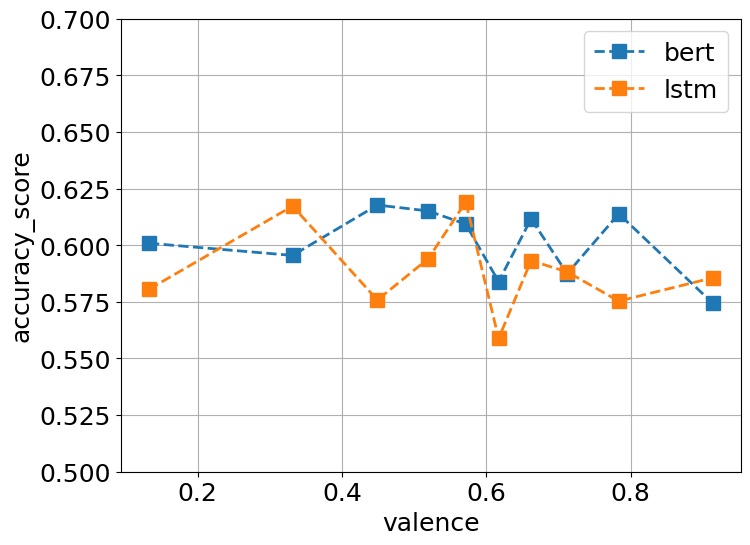

In [76]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm"], (0.5,0.7),
         metric=accuracy_score, use_percentile=True)

[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


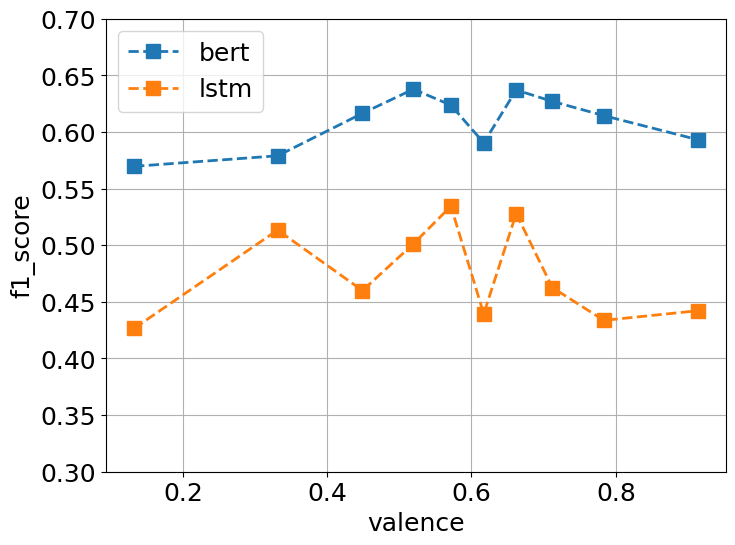

In [78]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm"], (0.3,0.7),
         metric=f1_score, use_percentile=True)

[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


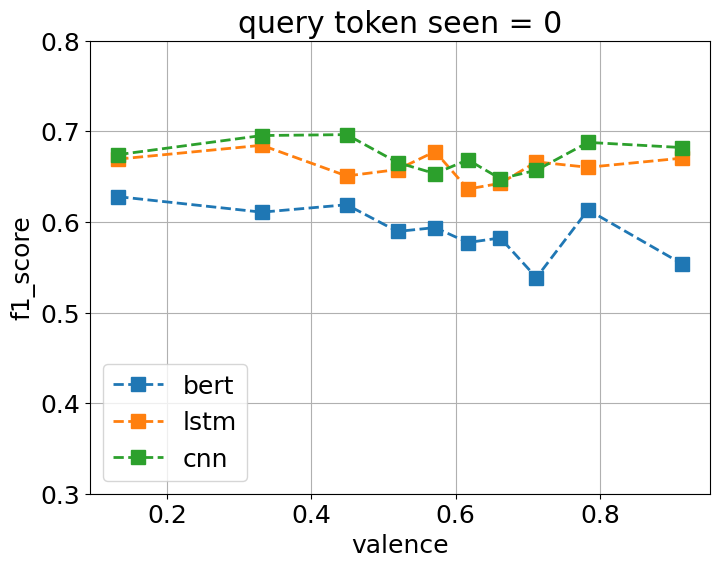

In [178]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm", "cnn"], (0.3,0.8),
         metric=f1_score, pos_label=0, use_percentile=True)

[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


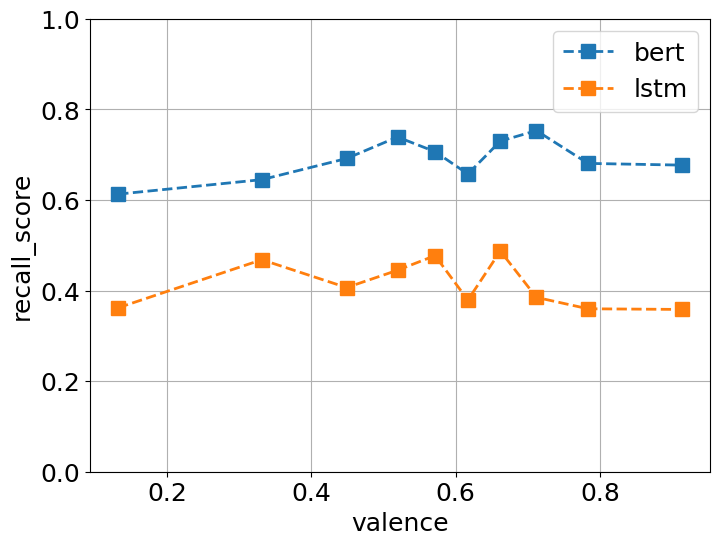

In [434]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True)

[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


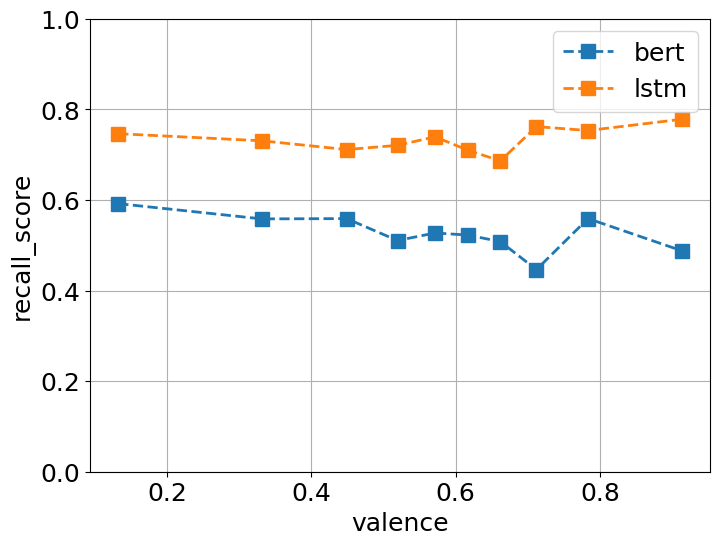

In [435]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True, pos_label=0)

[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]
[0.255 0.408 0.49  0.549 0.594 0.64  0.684 0.74  0.827]
[12396, 11025, 9656, 8266, 6840, 5518, 4006, 2693, 1309]


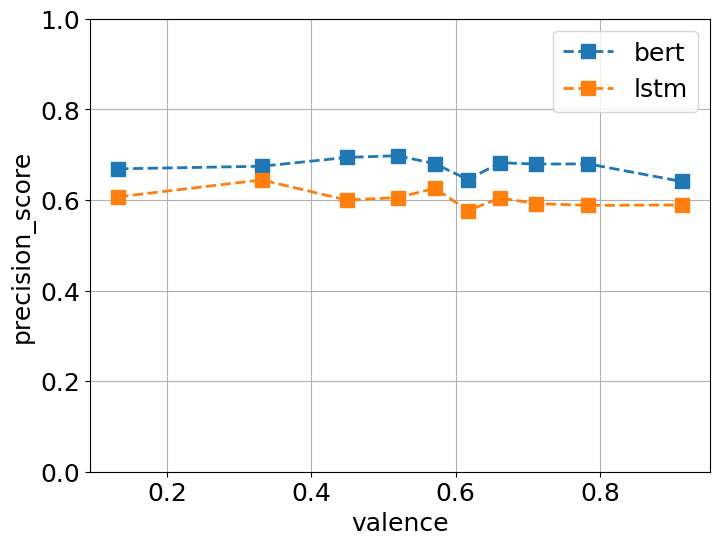

In [437]:
plot_acc(df_test_vad,
         'valence', ["bert", "lstm"], (0,1.0),
         metric=precision_score, use_percentile=True, pos_label=0)

[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]
[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]


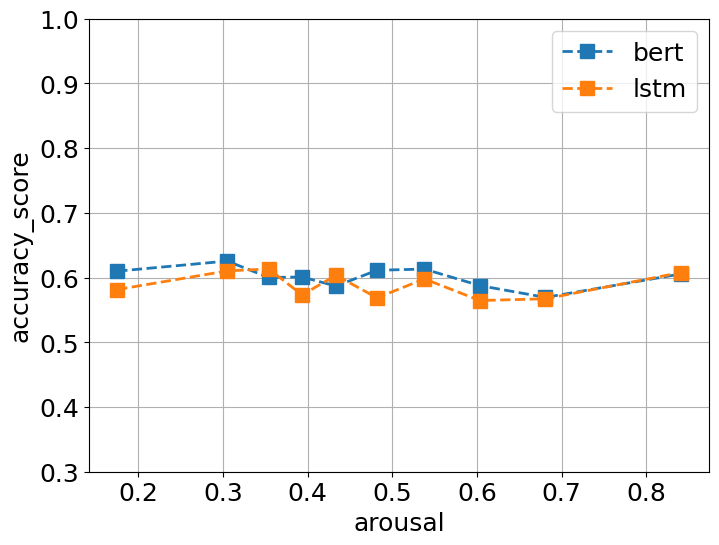

In [81]:
plot_acc(df_test_vad,
         'arousal', ["bert", "lstm"], (0.3,1.0),
         metric=accuracy_score, use_percentile=True)

[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]
[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]


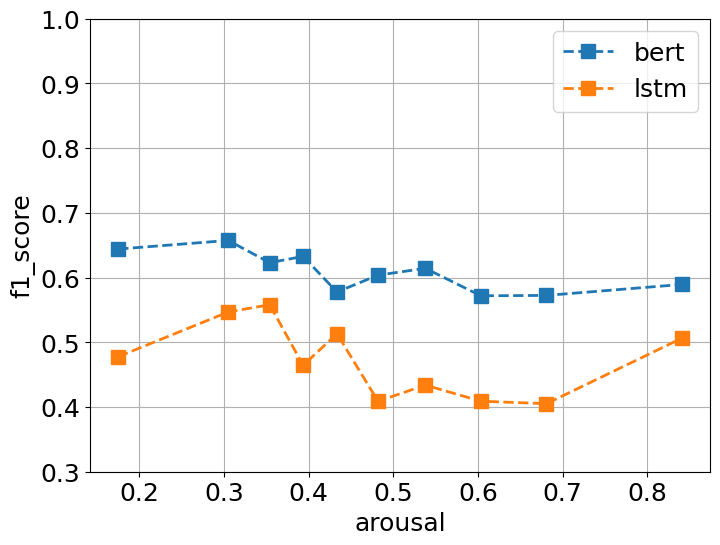

In [82]:
plot_acc(df_test_vad,
         'arousal', ["bert", "lstm"], (0.3,1.0),
         metric=f1_score, use_percentile=True)

[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]
[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]
[0.277 0.333 0.375 0.412 0.455 0.509 0.567 0.64  0.722]
[12419, 11025, 9628, 8267, 6896, 5499, 4134, 2746, 1372]


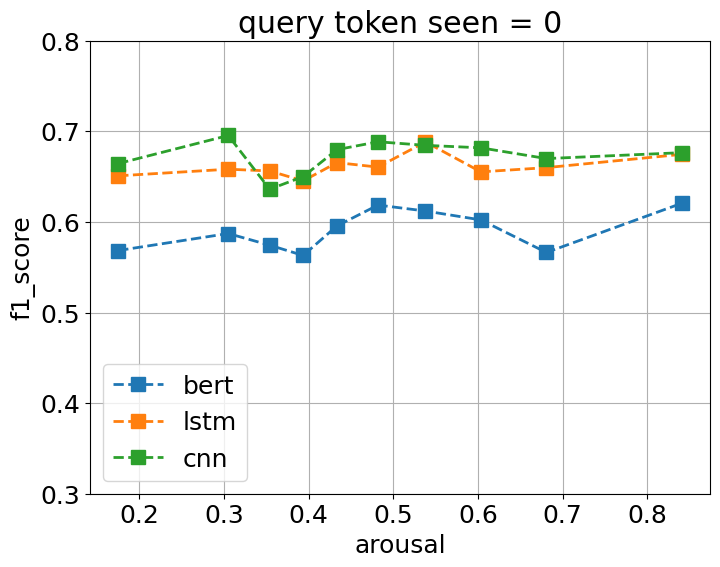

In [179]:
plot_acc(df_test_vad,
         'arousal', ["bert", "lstm", "cnn"], (0.3,0.8),
         metric=f1_score, pos_label=0, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


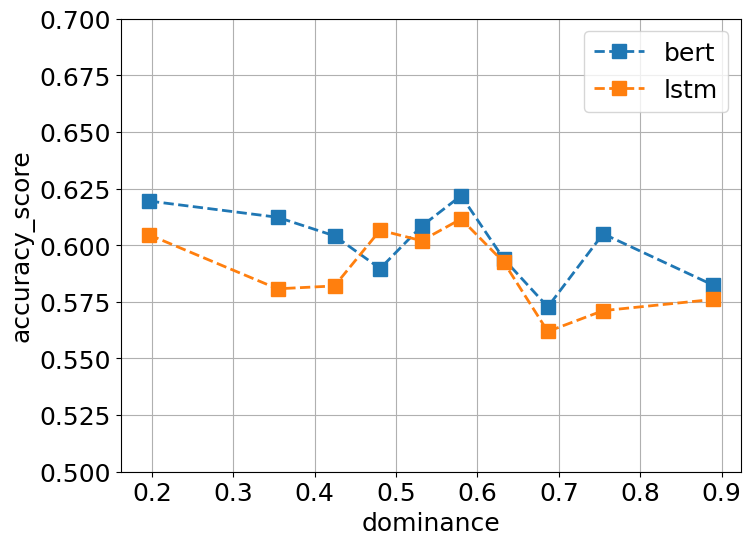

In [84]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0.5,0.7),
         metric=accuracy_score, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


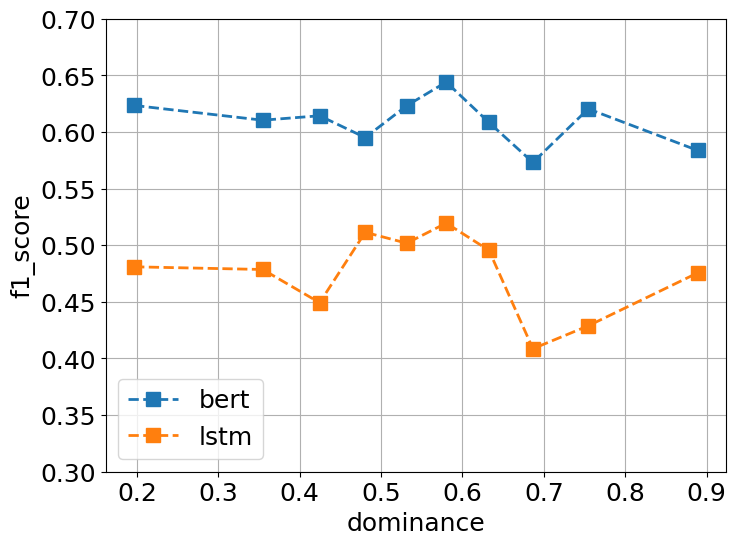

In [87]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0.3,0.7),
         metric=f1_score, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


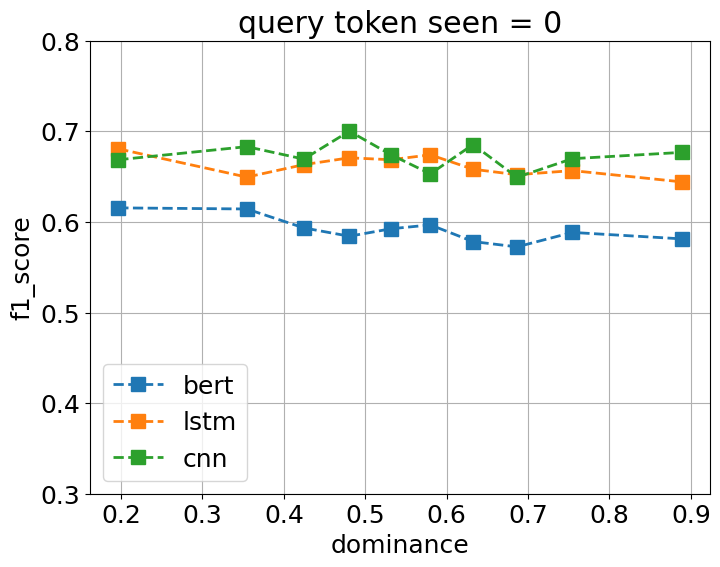

In [180]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm", "cnn"], (0.3,0.8),
         metric=f1_score, pos_label=0, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


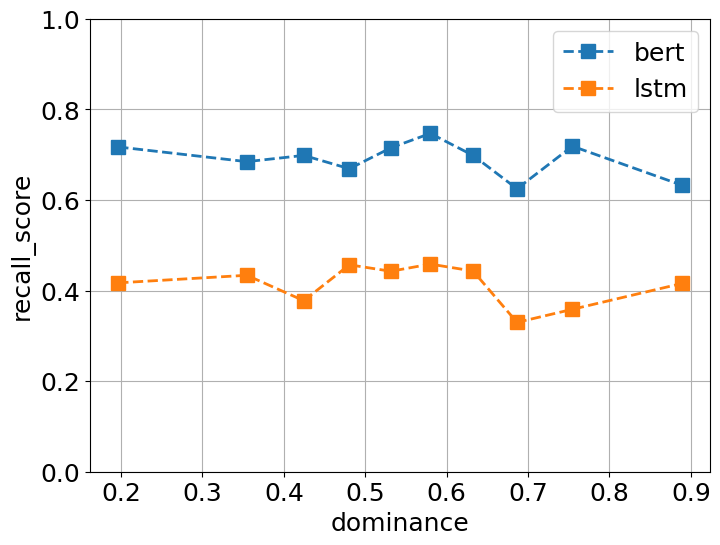

In [442]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


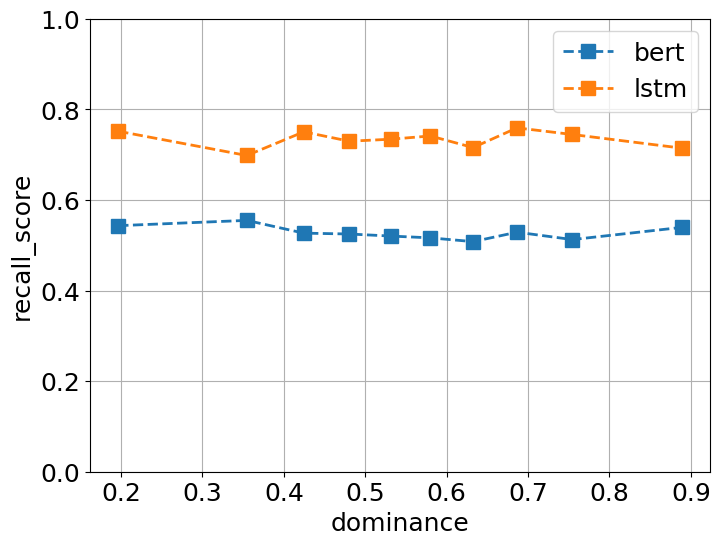

In [443]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True, pos_label=0)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


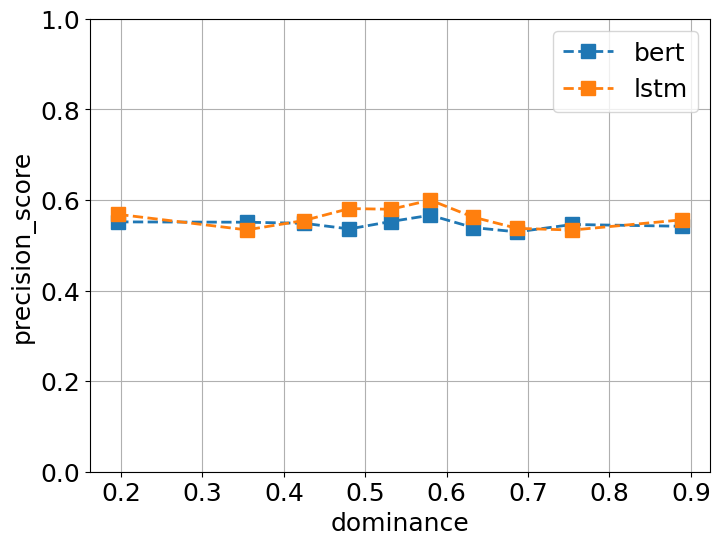

In [444]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0,1.0),
         metric=precision_score, use_percentile=True)

[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]
[0.312 0.397 0.452 0.509 0.554 0.606 0.659 0.714 0.795]
[12394, 11037, 9638, 8188, 6859, 5517, 4140, 2716, 1372]


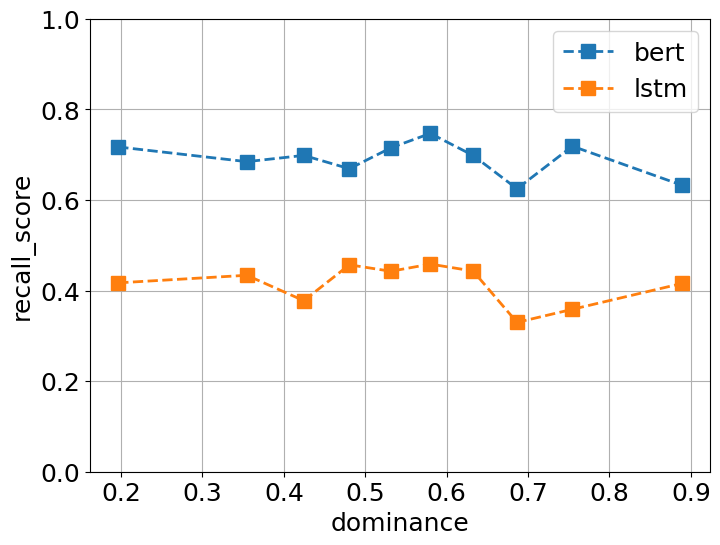

In [445]:
plot_acc(df_test_vad,
         'dominance', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True, pos_label=1)

# get unigram frequency

In [29]:
# get query lemma
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

query_list = df_test['query'].to_list()
df_test["query_lemma"] = [lemmatizer.lemmatize(w) for w in query_list]

In [30]:
# unigram frequency in english language
# https://www.kaggle.com/datasets/rtatman/english-word-frequency?resource=download
word_freq = pd.read_csv("unigram_freq.csv")

In [31]:
df_test = pd.merge(df_test, word_freq, how='left', left_on = 'query_lemma', right_on = "word")
df_test = df_test.drop(columns = ["word"])

In [32]:
df_test_unigram = df_test[df_test["count"].notnull()]
df_test_unigram["count"] = pd.to_numeric(df_test_unigram["count"])

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


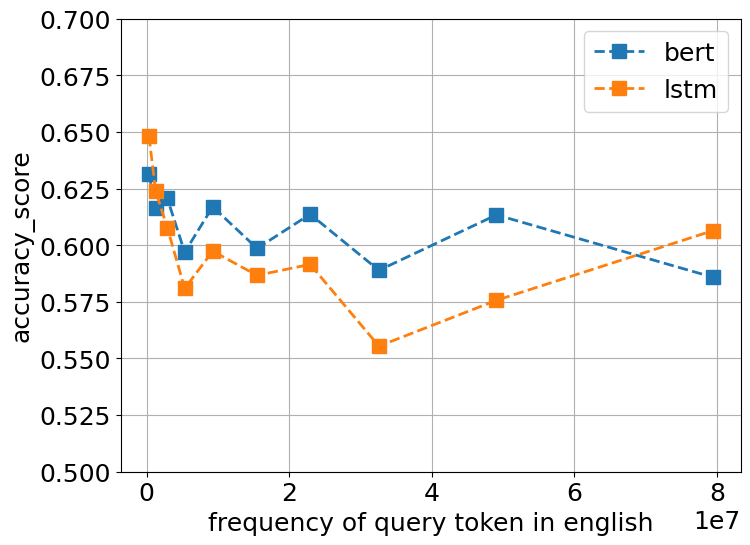

In [158]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0.5,0.7),
         metric=accuracy_score, use_percentile=True, xlabel='frequency of query token in english')

# less frequent words are better recalled than more frequent words

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


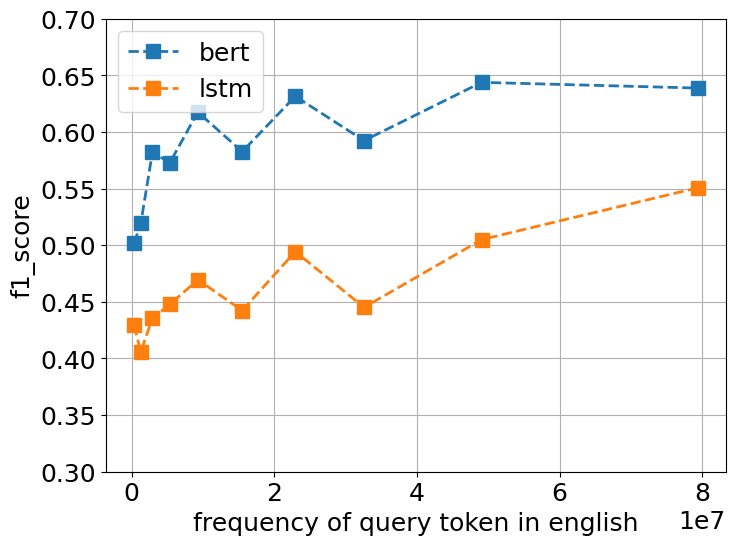

In [98]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0.3,0.7),
         metric=f1_score, use_percentile=True, xlabel='frequency of query token in english')

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


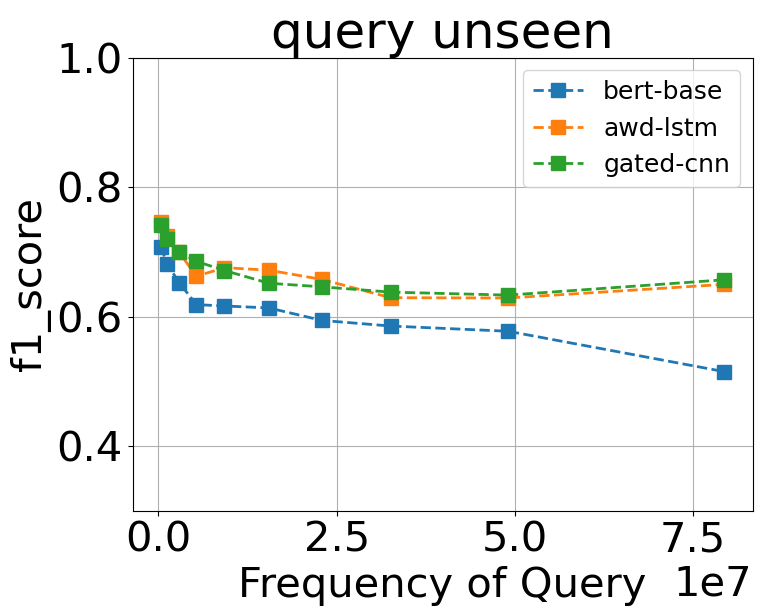

In [142]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm", "cnn"], y_lims=(0.3,1),
         metric=f1_score, pos_label=0, use_percentile=True, xlabel='Frequency of Query', do_title=True)

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


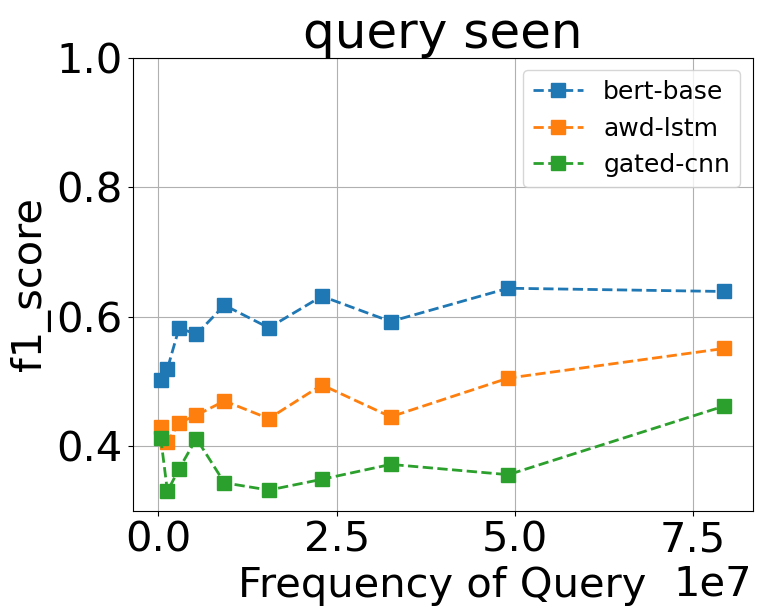

In [141]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm", "cnn"], y_lims=(0.3,1),
         metric=f1_score, pos_label=1, use_percentile=True, xlabel='Frequency of Query', do_title=True)

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


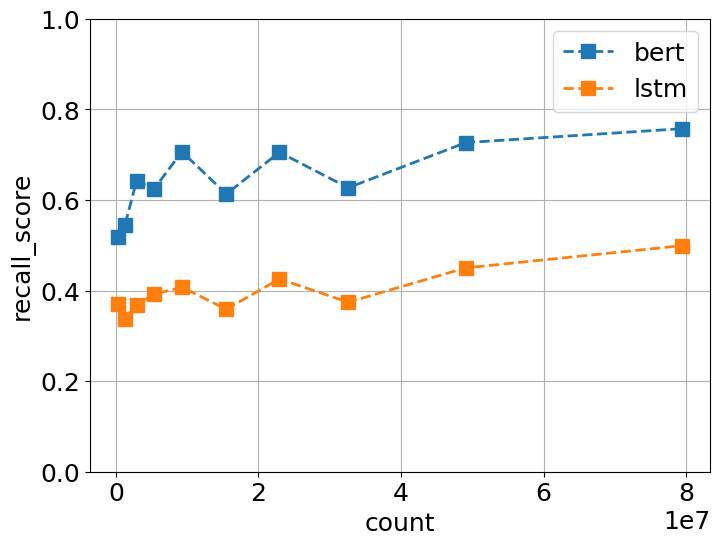

In [473]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True)
# among positives the more frequent the word is the better it is recalled

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


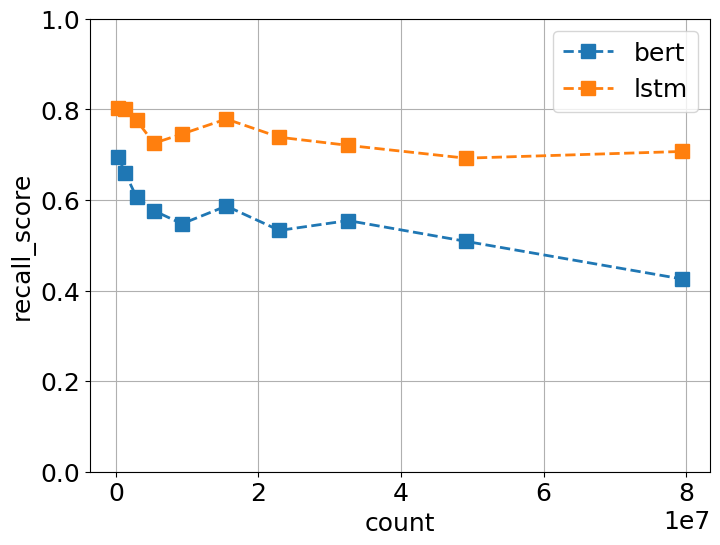

In [474]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0,1.0),
         metric=recall_score, use_percentile=True, pos_label=0)
# among negatives the more frequent a word is the harder to tell it is not there

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


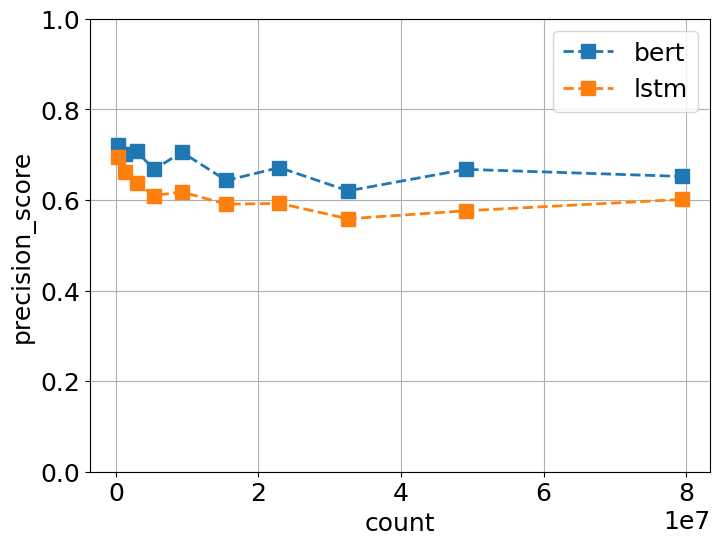

In [475]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0,1.0),
         metric=precision_score, use_percentile=True, pos_label=0)
# among negatives the more frequent a word is the harder to tell it is not there

[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]
[  628740.          1898217.          3897452.          6768275.
 11756315.         19218507.80000002 26651461.         38506956.
 59634216.40000004]
[18001, 15995, 13994, 11992, 10000, 8007, 5999, 3997, 2002]


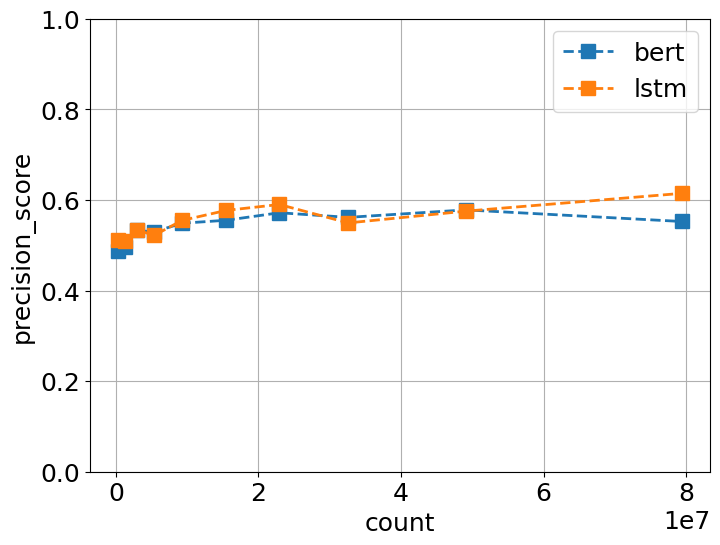

In [493]:
plot_acc(df_test_unigram[df_test_unigram["count"] < 1e8],
         'count', ["bert", "lstm"], (0,1.0),
         metric=precision_score, use_percentile=True)
# among negatives the more frequent a word is the harder to tell it is not there

## part of speech
get the pos tag for query lemma
https://www.nltk.org/api/nltk.tag.html#nltk.tag.pos_tag
different pos - https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
some explanation - https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

In [163]:
query_pos = []
for k in df_test["query_lemma"].to_list():
    query_pos.append(nltk.tag.pos_tag([k])[0][1])

In [28]:
nltk.tag.pos_tag([df_test["query_lemma"].iloc[0]])

[("'an", 'NNS')]

In [164]:
df_test['query_pos'] = query_pos #list(list(zip(*query_pos))[1])impos

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator


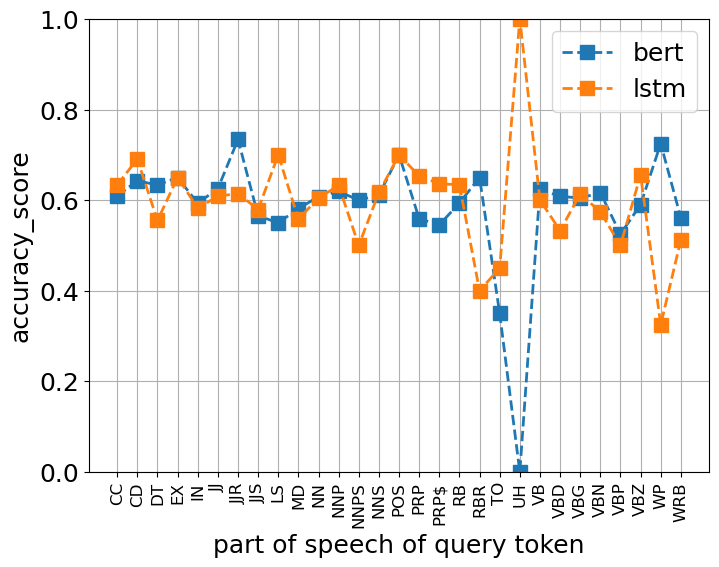

In [165]:
plot_acc(df_test,
         'query_pos', ["bert", "lstm"], (0,1.0),
         metric=accuracy_score, use_percentile=False, bin_cen_num=False, rotate_label=True, xlabel='part of speech of query token')

/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator


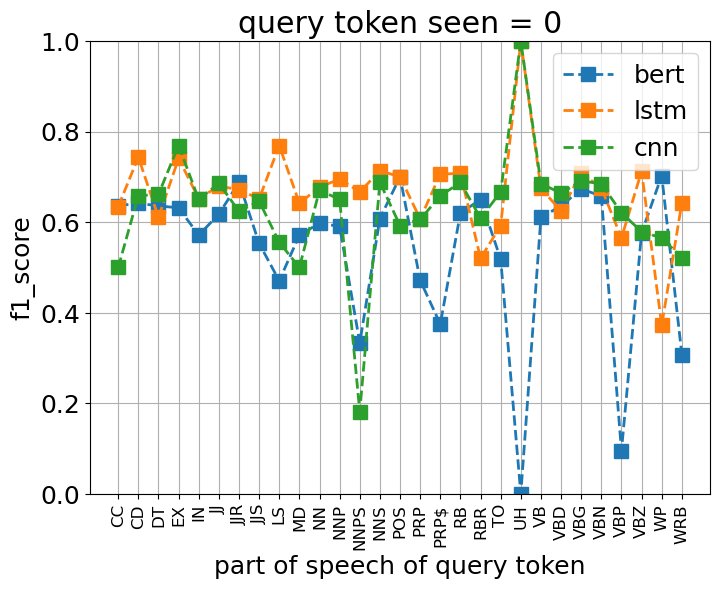

In [182]:
plot_acc(df_test,
         'query_pos', ["bert", "lstm", "cnn"], (0,1.0),
         metric=f1_score, pos_label=0, use_percentile=False, bin_cen_num=False, rotate_label=True, xlabel='part of speech of query token')

/opt/conda/envs/tf14/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator


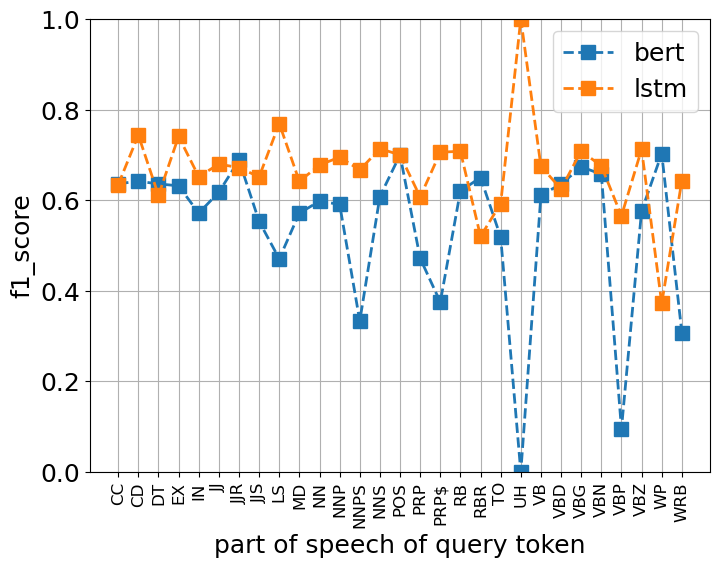

In [106]:
plot_acc(df_test,
         'query_pos', ["bert", "lstm"], (0,1.0),
         metric=f1_score, pos_label=0, use_percentile=False, bin_cen_num=False, rotate_label=True, xlabel='part of speech of query token')

## bias lexicon

In [202]:
with open ('bias-lexicon.txt') as f:
    bias_lemmas = [line.strip('\n') for line in f]

In [203]:
df_bias = df_test[df_test['query_lemma'].isin(bias_lemmas)]

In [529]:
len(df_bias["query"].unique())

248

In [204]:
accuracy_score_bert = accuracy_score(df_bias["label"], df_bias["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_bias["label"], df_bias["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_bias["label"], df_bias["cnn_pred_label"])

recall_score_bert = recall_score(df_bias["label"], df_bias["bert_pred_label"])
recall_score_lstm = recall_score(df_bias["label"], df_bias["lstm_pred_label"])
recall_score_cnn = recall_score(df_bias["label"], df_bias["cnn_pred_label"])

precision_score_bert = precision_score(df_bias["label"], df_bias["bert_pred_label"])
precision_score_lstm = precision_score(df_bias["label"], df_bias["lstm_pred_label"])
precision_score_cnn = precision_score(df_bias["label"], df_bias["cnn_pred_label"])

f1_score_bert = f1_score(df_bias["label"], df_bias["bert_pred_label"])
f1_score_lstm = f1_score(df_bias["label"], df_bias["lstm_pred_label"])
f1_score_cnn = f1_score(df_bias["label"], df_bias["cnn_pred_label"])

In [205]:
print("bias accuracy_score_bert {}".format(accuracy_score_bert))
print("bias accuracy_score_lstm {}".format(accuracy_score_lstm))
print("bias accuracy_score_cnn {}".format(accuracy_score_cnn))
print("bias recall_score_bert {}".format(recall_score_bert))
print("bias recall_score_lstm {}".format(recall_score_lstm))
print("bias recall_score_cnn {}".format(recall_score_cnn))
print("bias precision_score_bert {}".format(precision_score_bert))
print("bias precision_score_lstm {}".format(precision_score_lstm))
print("bias precision_score_cnn {}".format(precision_score_cnn))
print("bias f1_score_bert {}".format(f1_score_bert))
print("bias f1_score_lstm {}".format(f1_score_lstm))
print("bias f1_score_cnn {}".format(f1_score_cnn))

bias accuracy_score_bert 0.5897615708274895
bias accuracy_score_lstm 0.5802945301542777
bias accuracy_score_cnn 0.5361150070126227
bias recall_score_bert 0.7760758570386579
bias recall_score_lstm 0.424507658643326
bias recall_score_cnn 0.27206418672501825
bias precision_score_bert 0.5521536066424494
bias precision_score_lstm 0.5878787878787879
bias precision_score_cnn 0.5343839541547278
bias f1_score_bert 0.645239539114615
bias f1_score_lstm 0.4930114358322744
bias f1_score_cnn 0.360560657322378


## bias related lexicons

In [206]:
with open ('assertives_hooper1975.txt') as f:
    assertives_lemmas = [line.strip('\n') for line in f]

In [207]:
df_assertives = df_test[df_test['query_lemma'].isin(assertives_lemmas)]

In [208]:
accuracy_score_bert = accuracy_score(df_assertives["label"], df_assertives["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_assertives["label"], df_assertives["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_assertives["label"], df_assertives["cnn_pred_label"])

recall_score_bert = recall_score(df_assertives["label"], df_assertives["bert_pred_label"])
recall_score_lstm = recall_score(df_assertives["label"], df_assertives["lstm_pred_label"])
recall_score_cnn = recall_score(df_assertives["label"], df_assertives["cnn_pred_label"])

precision_score_bert = precision_score(df_assertives["label"], df_assertives["bert_pred_label"])
precision_score_lstm = precision_score(df_assertives["label"], df_assertives["lstm_pred_label"])
precision_score_cnn = precision_score(df_assertives["label"], df_assertives["cnn_pred_label"])

f1_score_bert = f1_score(df_assertives["label"], df_assertives["bert_pred_label"])
f1_score_lstm = f1_score(df_assertives["label"], df_assertives["lstm_pred_label"])
f1_score_cnn = f1_score(df_assertives["label"], df_assertives["cnn_pred_label"])

In [209]:
print("assertives accuracy_score_bert {}".format(accuracy_score_bert))
print("assertives accuracy_score_lstm {}".format(accuracy_score_lstm))
print("assertives accuracy_score_cnn {}".format(accuracy_score_cnn))
print("assertives recall_score_bert {}".format(recall_score_bert))
print("assertives recall_score_lstm {}".format(recall_score_lstm))
print("assertives recall_score_cnn {}".format(recall_score_cnn))
print("assertives precision_score_bert {}".format(precision_score_bert))
print("assertives precision_score_lstm {}".format(precision_score_lstm))
print("assertives precision_score_cnn {}".format(precision_score_cnn))
print("assertives f1_score_bert {}".format(f1_score_bert))
print("assertives f1_score_lstm {}".format(f1_score_lstm))
print("assertives f1_score_cnn {}".format(f1_score_cnn))

assertives accuracy_score_bert 0.5714285714285714
assertives accuracy_score_lstm 0.6964285714285714
assertives accuracy_score_cnn 0.8214285714285714
assertives recall_score_bert 0.64
assertives recall_score_lstm 0.54
assertives recall_score_cnn 0.7
assertives precision_score_bert 0.5161290322580645
assertives precision_score_lstm 0.7105263157894737
assertives precision_score_cnn 0.875
assertives f1_score_bert 0.5714285714285714
assertives f1_score_lstm 0.6136363636363636
assertives f1_score_cnn 0.7777777777777777


In [210]:
with open ('factives_hooper1975.txt') as f:
    fractives_lemmas = [line.strip('\n') for line in f]

In [211]:
df_fractives = df_test[df_test['query_lemma'].isin(fractives_lemmas)]

In [212]:
accuracy_score_bert = accuracy_score(df_fractives["label"], df_fractives["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_fractives["label"], df_fractives["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_fractives["label"], df_fractives["cnn_pred_label"])

recall_score_bert = recall_score(df_fractives["label"], df_fractives["bert_pred_label"])
recall_score_lstm = recall_score(df_fractives["label"], df_fractives["lstm_pred_label"])
recall_score_cnn = recall_score(df_fractives["label"], df_fractives["cnn_pred_label"])

precision_score_bert = precision_score(df_fractives["label"], df_fractives["bert_pred_label"])
precision_score_lstm = precision_score(df_fractives["label"], df_fractives["lstm_pred_label"])
precision_score_cnn = precision_score(df_fractives["label"], df_fractives["cnn_pred_label"])

f1_score_bert = f1_score(df_fractives["label"], df_fractives["bert_pred_label"])
f1_score_lstm = f1_score(df_fractives["label"], df_fractives["lstm_pred_label"])
f1_score_cnn = f1_score(df_fractives["label"], df_fractives["cnn_pred_label"])

In [213]:
print("fractives accuracy_score_bert {}".format(accuracy_score_bert))
print("fractives accuracy_score_lstm {}".format(accuracy_score_lstm))
print("fractives accuracy_score_cnn {}".format(accuracy_score_cnn))
print("fractives recall_score_bert {}".format(recall_score_bert))
print("fractives recall_score_lstm {}".format(recall_score_lstm))
print("fractives recall_score_cnn {}".format(recall_score_cnn))
print("fractives precision_score_bert {}".format(precision_score_bert))
print("fractives precision_score_lstm {}".format(precision_score_lstm))
print("fractives precision_score_cnn {}".format(precision_score_cnn))
print("fractives f1_score_bert {}".format(f1_score_bert))
print("fractives f1_score_lstm {}".format(f1_score_lstm))
print("fractives f1_score_cnn {}".format(f1_score_cnn))

fractives accuracy_score_bert 0.515625
fractives accuracy_score_lstm 0.484375
fractives accuracy_score_cnn 0.53125
fractives recall_score_bert 0.8666666666666667
fractives recall_score_lstm 0.16666666666666666
fractives recall_score_cnn 0.23333333333333334
fractives precision_score_bert 0.49056603773584906
fractives precision_score_lstm 0.38461538461538464
fractives precision_score_cnn 0.5
fractives f1_score_bert 0.6265060240963856
fractives f1_score_lstm 0.2325581395348837
fractives f1_score_cnn 0.3181818181818182


In [233]:
with open ('hedges_hyland2005.txt') as f:
    hedges_lemmas = [line.strip('\n') for line in f]

In [234]:
df_hedges = df_test[df_test['query_lemma'].isin(hedges_lemmas)]

In [235]:
accuracy_score_bert = accuracy_score(df_hedges["label"], df_hedges["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_hedges["label"], df_hedges["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_hedges["label"], df_hedges["cnn_pred_label"])

recall_score_bert = recall_score(df_hedges["label"], df_hedges["bert_pred_label"])
recall_score_lstm = recall_score(df_hedges["label"], df_hedges["lstm_pred_label"])
recall_score_cnn = recall_score(df_hedges["label"], df_hedges["cnn_pred_label"])

precision_score_bert = precision_score(df_hedges["label"], df_hedges["bert_pred_label"])
precision_score_lstm = precision_score(df_hedges["label"], df_hedges["lstm_pred_label"])
precision_score_cnn = precision_score(df_hedges["label"], df_hedges["cnn_pred_label"])

f1_score_bert = f1_score(df_hedges["label"], df_hedges["bert_pred_label"])
f1_score_lstm = f1_score(df_hedges["label"], df_hedges["lstm_pred_label"])
f1_score_cnn = f1_score(df_hedges["label"], df_hedges["cnn_pred_label"])

In [236]:
print("hedges accuracy_score_bert {}".format(accuracy_score_bert))
print("hedges accuracy_score_lstm {}".format(accuracy_score_lstm))
print("hedges accuracy_score_cnn {}".format(accuracy_score_cnn))
print("hedges recall_score_bert {}".format(recall_score_bert))
print("hedges recall_score_lstm {}".format(recall_score_lstm))
print("hedges recall_score_cnn {}".format(recall_score_cnn))
print("hedges precision_score_bert {}".format(precision_score_bert))
print("hedges precision_score_lstm {}".format(precision_score_lstm))
print("hedges precision_score_cnn {}".format(precision_score_cnn))
print("hedges f1_score_bert {}".format(f1_score_bert))
print("hedges f1_score_lstm {}".format(f1_score_lstm))
print("hedges f1_score_cnn {}".format(f1_score_cnn))

hedges accuracy_score_bert 0.5984555984555985
hedges accuracy_score_lstm 0.5328185328185329
hedges accuracy_score_cnn 0.5328185328185329
hedges recall_score_bert 0.504
hedges recall_score_lstm 0.296
hedges recall_score_cnn 0.096
hedges precision_score_bert 0.6
hedges precision_score_lstm 0.5285714285714286
hedges precision_score_cnn 0.6
hedges f1_score_bert 0.5478260869565217
hedges f1_score_lstm 0.37948717948717947
hedges f1_score_cnn 0.16551724137931034


In [221]:
with open ('implicatives_karttunen1971.txt') as f:
    implicatives_lemmas = [line.strip('\n') for line in f]

In [222]:
df_implicatives = df_test[df_test['query_lemma'].isin(implicatives_lemmas)]

In [223]:
accuracy_score_bert = accuracy_score(df_implicatives["label"], df_implicatives["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_implicatives["label"], df_implicatives["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_implicatives["label"], df_implicatives["cnn_pred_label"])

recall_score_bert = recall_score(df_implicatives["label"], df_implicatives["bert_pred_label"])
recall_score_lstm = recall_score(df_implicatives["label"], df_implicatives["lstm_pred_label"])
recall_score_cnn = recall_score(df_implicatives["label"], df_implicatives["cnn_pred_label"])

precision_score_bert = precision_score(df_implicatives["label"], df_implicatives["bert_pred_label"])
precision_score_lstm = precision_score(df_implicatives["label"], df_implicatives["lstm_pred_label"])
precision_score_cnn = precision_score(df_implicatives["label"], df_implicatives["cnn_pred_label"])

f1_score_bert = f1_score(df_implicatives["label"], df_implicatives["bert_pred_label"])
f1_score_lstm = f1_score(df_implicatives["label"], df_implicatives["lstm_pred_label"])
f1_score_cnn = f1_score(df_implicatives["label"], df_implicatives["cnn_pred_label"])

In [224]:
print("hedges accuracy_score_bert {}".format(accuracy_score_bert))
print("hedges accuracy_score_lstm {}".format(accuracy_score_lstm))
print("hedges accuracy_score_cnn {}".format(accuracy_score_cnn))
print("hedges recall_score_bert {}".format(recall_score_bert))
print("hedges recall_score_lstm {}".format(recall_score_lstm))
print("hedges recall_score_cnn {}".format(recall_score_cnn))
print("hedges precision_score_bert {}".format(precision_score_bert))
print("hedges precision_score_lstm {}".format(precision_score_lstm))
print("hedges precision_score_cnn {}".format(precision_score_cnn))
print("hedges f1_score_bert {}".format(f1_score_bert))
print("hedges f1_score_lstm {}".format(f1_score_lstm))
print("hedges f1_score_cnn {}".format(f1_score_cnn))

hedges accuracy_score_bert 0.6351351351351351
hedges accuracy_score_lstm 0.527027027027027
hedges accuracy_score_cnn 0.5135135135135135
hedges recall_score_bert 0.7714285714285715
hedges recall_score_lstm 0.37142857142857144
hedges recall_score_cnn 0.2857142857142857
hedges precision_score_bert 0.5869565217391305
hedges precision_score_lstm 0.5
hedges precision_score_cnn 0.47619047619047616
hedges f1_score_bert 0.6666666666666667
hedges f1_score_lstm 0.42622950819672134
hedges f1_score_cnn 0.3571428571428571


In [225]:
with open ('report_verbs.txt') as f:
    report_verbs = [line.strip('\n') for line in f]

In [226]:
df_report_verbs = df_test[df_test['query_lemma'].isin(report_verbs)]

In [227]:
accuracy_score_bert = accuracy_score(df_report_verbs["label"], df_report_verbs["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_report_verbs["label"], df_report_verbs["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_report_verbs["label"], df_report_verbs["cnn_pred_label"])

recall_score_bert = recall_score(df_report_verbs["label"], df_report_verbs["bert_pred_label"])
recall_score_lstm = recall_score(df_report_verbs["label"], df_report_verbs["lstm_pred_label"])
recall_score_cnn = recall_score(df_report_verbs["label"], df_report_verbs["cnn_pred_label"])

precision_score_bert = precision_score(df_report_verbs["label"], df_report_verbs["bert_pred_label"])
precision_score_lstm = precision_score(df_report_verbs["label"], df_report_verbs["lstm_pred_label"])
precision_score_cnn = precision_score(df_report_verbs["label"], df_report_verbs["cnn_pred_label"])

f1_score_bert = f1_score(df_report_verbs["label"], df_report_verbs["bert_pred_label"])
f1_score_lstm = f1_score(df_report_verbs["label"], df_report_verbs["lstm_pred_label"])
f1_score_cnn = f1_score(df_report_verbs["label"], df_report_verbs["cnn_pred_label"])

In [228]:
print("report_verbs accuracy_score_bert {}".format(accuracy_score_bert))
print("report_verbs accuracy_score_lstm {}".format(accuracy_score_lstm))
print("report_verbs accuracy_score_cnn {}".format(accuracy_score_cnn))
print("report_verbs recall_score_bert {}".format(recall_score_bert))
print("report_verbs recall_score_lstm {}".format(recall_score_lstm))
print("report_verbs recall_score_cnn {}".format(recall_score_cnn))
print("report_verbs precision_score_bert {}".format(precision_score_bert))
print("report_verbs precision_score_lstm {}".format(precision_score_lstm))
print("report_verbs precision_score_cnn {}".format(precision_score_cnn))
print("report_verbs f1_score_bert {}".format(f1_score_bert))
print("report_verbs f1_score_lstm {}".format(f1_score_lstm))
print("report_verbs f1_score_cnn {}".format(f1_score_cnn))

report_verbs accuracy_score_bert 0.6182336182336182
report_verbs accuracy_score_lstm 0.6210826210826211
report_verbs accuracy_score_cnn 0.6324786324786325
report_verbs recall_score_bert 0.7295597484276729
report_verbs recall_score_lstm 0.3270440251572327
report_verbs recall_score_cnn 0.31446540880503143
report_verbs precision_score_bert 0.5603864734299517
report_verbs precision_score_lstm 0.6666666666666666
report_verbs precision_score_cnn 0.7142857142857143
report_verbs f1_score_bert 0.633879781420765
report_verbs f1_score_lstm 0.4388185654008438
report_verbs f1_score_cnn 0.43668122270742354


In [14]:
accuracy_score_bert = accuracy_score(df_test["label"], df_test["bert_pred_label"])
accuracy_score_lstm = accuracy_score(df_test["label"], df_test["lstm_pred_label"])
accuracy_score_cnn = accuracy_score(df_test["label"], df_test["cnn_pred_label"])

recall_score_bert = recall_score(df_test["label"], df_test["bert_pred_label"])
recall_score_lstm = recall_score(df_test["label"], df_test["lstm_pred_label"])
recall_score_cnn = recall_score(df_test["label"], df_test["cnn_pred_label"])

precision_score_bert = precision_score(df_test["label"], df_test["bert_pred_label"])
precision_score_lstm = precision_score(df_test["label"], df_test["lstm_pred_label"])
precision_score_cnn = precision_score(df_test["label"], df_test["cnn_pred_label"])

f1_score_bert = f1_score(df_test["label"], df_test["bert_pred_label"], average='macro')
f1_score_lstm = f1_score(df_test["label"], df_test["lstm_pred_label"], average='macro')
f1_score_cnn = f1_score(df_test["label"], df_test["cnn_pred_label"], average='macro')

In [15]:
print("all words accuracy_score_bert {}".format(accuracy_score_bert))
print("all words accuracy_score_lstm {}".format(accuracy_score_lstm))
print("all words accuracy_score_cnn {}".format(accuracy_score_cnn))
print("all words recall_score_bert {}".format(recall_score_bert))
print("all words recall_score_lstm {}".format(recall_score_lstm))
print("all words recall_score_cnn {}".format(recall_score_cnn))
print("all words precision_score_bert {}".format(precision_score_bert))
print("all words precision_score_lstm {}".format(precision_score_lstm))
print("all words precision_score_cnn {}".format(precision_score_cnn))
print("all words f1_score_bert {}".format(f1_score_bert))
print("all words f1_score_lstm {}".format(f1_score_lstm))
print("all words f1_score_cnn {}".format(f1_score_cnn))

all words accuracy_score_bert 0.6099758523096097
all words accuracy_score_lstm 0.6052761405239789
all words accuracy_score_cnn 0.5719107833718484
all words recall_score_bert 0.6869123839187864
all words recall_score_lstm 0.4085481917286728
all words recall_score_cnn 0.2958989444540578
all words precision_score_bert 0.5538554553064832
all words precision_score_lstm 0.5887291164491729
all words precision_score_cnn 0.5451647183846972
all words f1_score_bert 0.6099479047998853
all words f1_score_lstm 0.5816903404042462
all words f1_score_cnn 0.527842080529636


## surprisal??

In [33]:
df_test['cnn_surprisal'] = torch.load('surp_cnn_test.pt')

In [238]:
cnn_surp = torch.load('surp_cnn_test.pt')

In [239]:
len(cnn_surp)

38513

In [240]:
len(df_test)

38512

[ 2.36961613  4.13371944  5.37352896  6.47330008  7.62565708  8.81971169
 10.33447266 12.08444786 14.46306229]
[34661, 30809, 26955, 23108, 19256, 15400, 11554, 7698, 3849]


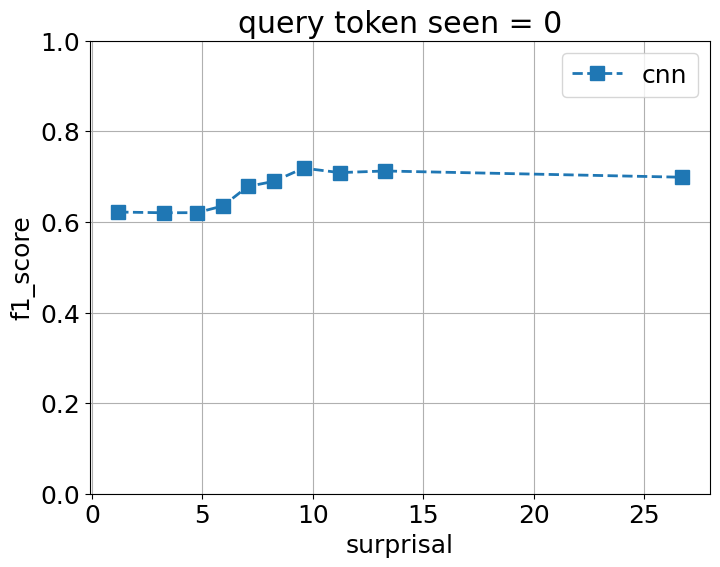

In [250]:
plot_acc(df_test, 'cnn_surp', ["cnn"], (0.0,1.0), use_percentile=True, metric=f1_score, pos_label=0, xlabel='surprisal')

[ 2.36961613  4.13371944  5.37352896  6.47330008  7.62565708  8.81971169
 10.33447266 12.08444786 14.46306229]
[34661, 30809, 26955, 23108, 19256, 15400, 11554, 7698, 3849]


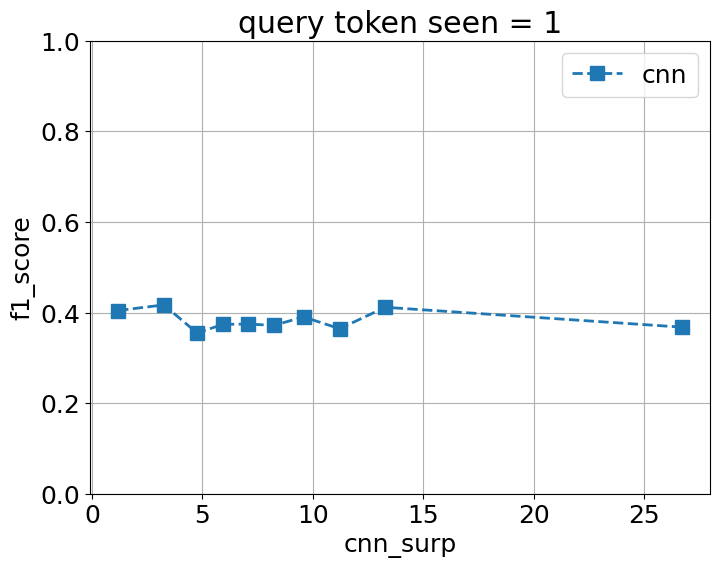

In [249]:
plot_acc(df_test, 'cnn_surp', ["cnn"], (0.0,1.0), use_percentile=True, metric=f1_score)

[ 2.49057484  3.80036221  4.83449287  5.90505056  7.11667299  8.47454681
  9.95489101 11.58453236 13.25711403]
[34661, 30810, 26959, 23108, 19256, 15405, 11554, 7703, 3852]


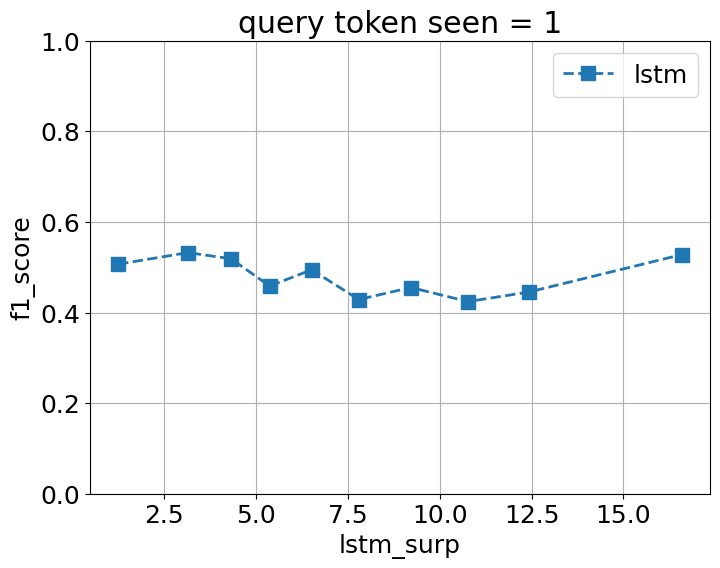

In [12]:
plot_acc(df_test, 'lstm_surp', ["lstm"], (0.0,1.0), use_percentile=True, metric=f1_score)

[ 2.49057484  3.80036221  4.83449287  5.90505056  7.11667299  8.47454681
  9.95489101 11.58453236 13.25711403]
[34661, 30810, 26959, 23108, 19256, 15405, 11554, 7703, 3852]


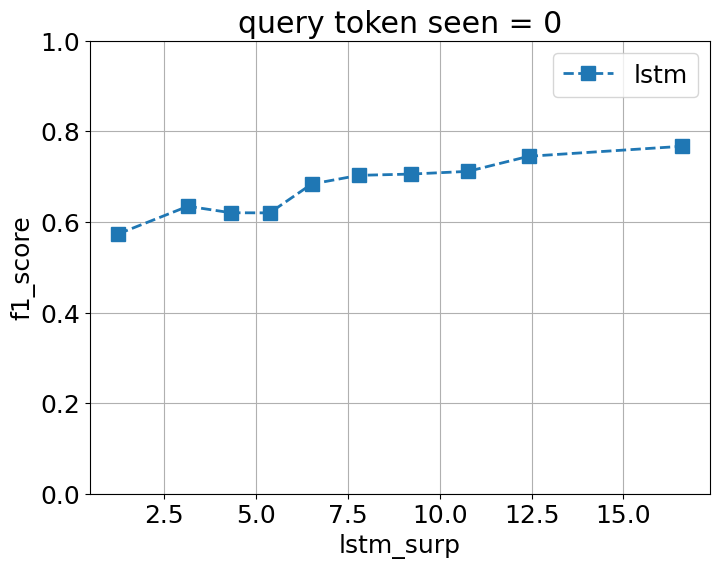

In [13]:
plot_acc(df_test, 'lstm_surp', ["lstm"], (0.0,1.0), use_percentile=True, metric=f1_score, pos_label=0)

In [36]:
# labelx - surp
def plot_surp(df, labelx, model_list, y_lims=(0.5,1.0), metric=None, pos_label=1, use_percentile=True,
            round_bins=False, bin_cen_num=True, rotate_label=False, xlabel=False,
             legend_names=["bert-base", "awd-lstm", "gated-cnn"]):
 
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.gca()
    for idx, model_name in enumerate(model_list):
        new_label = model_name+'_'+labelx
        K = 10
        if use_percentile:
            non_boundary_bin_edges = np.array([np.percentile(df[new_label], i) for i in range(K,100,K)])
            bins_edges = np.zeros(len(non_boundary_bin_edges)+2)
            bins_edges[1:-1] = non_boundary_bin_edges
            bins_edges[0], bins_edges[-1] = min(df[new_label]), max(df[new_label])
            
            num_bins = len(non_boundary_bin_edges) + 1
            print(non_boundary_bin_edges)
            print([np.sum(df[new_label] >t) for t in non_boundary_bin_edges])

            bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
            sample_bin_ids = np.digitize(df[new_label], non_boundary_bin_edges)
            
            num_samples_in_bins = np.zeros(num_bins)
            acc_in_bins = np.zeros(num_bins)
            #acc_in_bins_std = np.zeros(num_bins)

            for bin in range(num_bins):
                num_samples_in_bins[bin] = len(df[model_name + "_success"][sample_bin_ids == bin])
                if num_samples_in_bins[bin] > 0:
                    #acc_in_bins[bin] = np.sum(df[model_name + "_success"][sample_bin_ids == bin]) / num_samples_in_bins[bin]
                    if metric.__name__ != "accuracy_score":
                        acc_in_bins[bin] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin],
                                                 pos_label=pos_label)
                    elif metric.__name__ == "accuracy_score":
                        acc_in_bins[bin] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin])
                    
        else:
            if bin_cen_num:
                bin_centers = np.array(list(range(min(df[new_label]), max(df[new_label])+1)))
                sample_bin_ids = df[new_label]
                
            else:
                bin_centers = sorted(df[new_label].unique())
                sample_bin_ids = df[new_label]
                
            num_bins = len(bin_centers)
            num_samples_in_bins = np.zeros(num_bins)
            acc_in_bins = np.zeros(num_bins)
            #acc_in_bins_std = np.zeros(num_bins)

            for i, bin in enumerate(bin_centers):
                num_samples_in_bins[i] = len(df[model_name + "_success"][sample_bin_ids == bin])
                if num_samples_in_bins[i] > 0:
                    #acc_in_bins[bin] = np.sum(df[model_name + "_success"][sample_bin_ids == bin]) / num_samples_in_bins[bin]
                    if metric.__name__ != "accuracy_score":
                        acc_in_bins[i] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin],
                                                 pos_label=pos_label, average='macro')
                    else:
                        acc_in_bins[i] = metric(df["label"][sample_bin_ids == bin],
                                          df[model_name + "_pred_label"][sample_bin_ids == bin])
        
                    

        plt.plot(bin_centers,
                 acc_in_bins,
                 's--',
                 label=legend_names[idx],
                 linewidth=2,
                 markersize=10,
                )
        #plt.fill_between(bin_centers,
        #                 acc_in_bins-acc_in_bins_std,
        #                 acc_in_bins+acc_in_bins_std,
        #                 alpha=0.1
        #                )
        #plt.plot(bin_centers, 1.0* num_samples_in_bins/np.sum(num_samples_in_bins), '^--')
        #print(1.0* num_samples_in_bins/np.sum(num_samples_in_bins))
        if xlabel:
            plt.xlabel(xlabel)
        else:
            plt.xlabel(labelx)
        plt.ylabel(metric.__name__)
        plt.ylim(y_lims)
    plt.legend(fontsize=18)
    plt.grid()
    if pos_label:
        plt.title("query seen")
    else:
        plt.title("query unseen")
    if rotate_label:
        ax.set_xticklabels(bin_centers, fontsize=12, rotation=90)
    plt.savefig(labelx+"_metric"+metric.__name__+"_pos_label_"+str(pos_label)+"_.png", 
               bbox_inches='tight', 
               transparent=True)

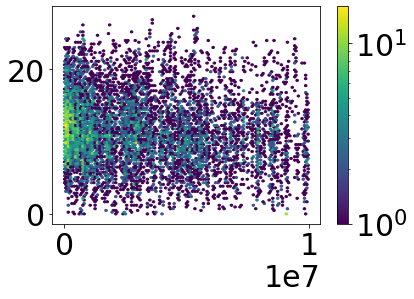

In [45]:
plt.hexbin(df_test["count"][df_test["count"]<1e7], df_test["bert_surp"][df_test["count"]<1e7], bins='log')
plt.colorbar()

[ 3.00738735  4.88186417  6.17338314  7.21821222  8.04099846  8.82046204
  9.57924938 10.3189518  11.10094852]
[16546, 14708, 12869, 11031, 9192, 7354, 5516, 3677, 1839]
[ 1.72254491  2.94180822  3.81073875  4.62658205  5.43132782  6.38147745
  7.42131786  8.71290398 10.22616024]
[16546, 14708, 12869, 11031, 9192, 7354, 5516, 3677, 1839]
[1.34833126 2.90749598 3.94375062 4.82363329 5.64718819 6.42191486
 7.33723354 8.372509   9.82501984]
[16546, 14708, 12869, 11031, 9192, 7354, 5513, 3672, 1838]


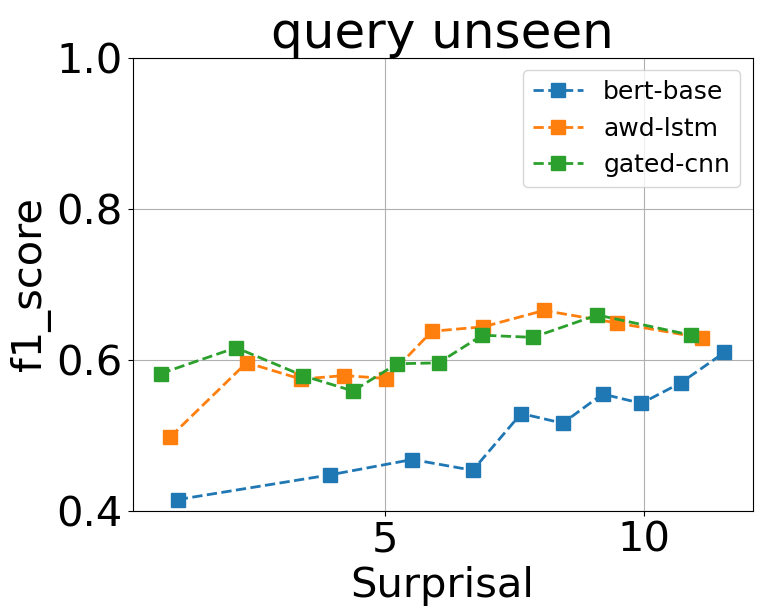

In [37]:
plot_surp(df_test[(df_test["lstm_surp"] < 12) & (df_test["cnn_surp"] < 12) & ((df_test["bert_surp"] < 12))],
          'surp', ["bert", "lstm", "cnn"], (0.4,1.0), use_percentile=True, metric=f1_score, pos_label=0,
         xlabel="Surprisal")

[ 3.00738735  4.88186417  6.17338314  7.21821222  8.04099846  8.82046204
  9.57924938 10.3189518  11.10094852]
[16546, 14708, 12869, 11031, 9192, 7354, 5516, 3677, 1839]
[ 1.72254491  2.94180822  3.81073875  4.62658205  5.43132782  6.38147745
  7.42131786  8.71290398 10.22616024]
[16546, 14708, 12869, 11031, 9192, 7354, 5516, 3677, 1839]
[1.34833126 2.90749598 3.94375062 4.82363329 5.64718819 6.42191486
 7.33723354 8.372509   9.82501984]
[16546, 14708, 12869, 11031, 9192, 7354, 5513, 3672, 1838]


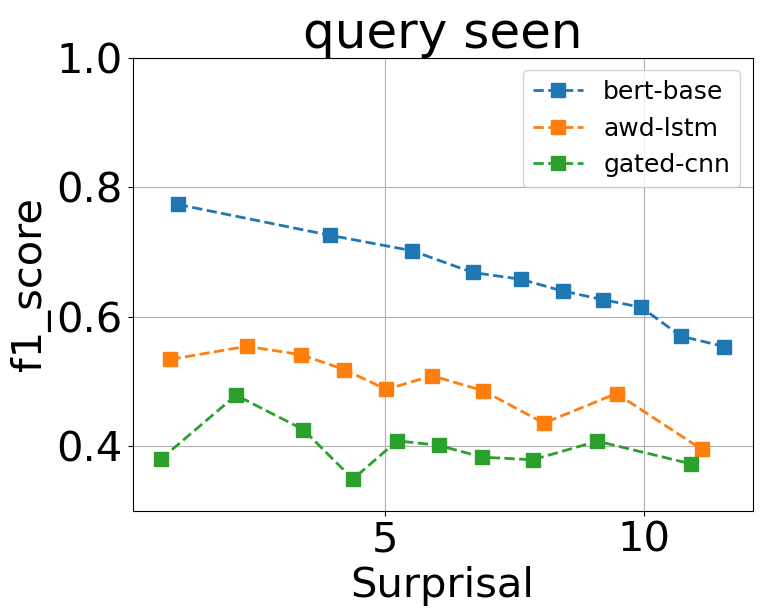

In [153]:
plot_surp(df_test[(df_test["lstm_surp"] < 12) & (df_test["cnn_surp"] < 12) & ((df_test["bert_surp"] < 12))], 'surp', ["bert","lstm", "cnn"], (0.3,1.0), use_percentile=True, metric=f1_score, pos_label=1,
         xlabel="Surprisal")

In [34]:
len(df_test[df_test["lstm_surp"] > 12])

6759

In [30]:
len(df_test[df_test["cnn_surp"] > 13])

6161